***
# W4: NLP Disaster Tweets
***

This project is a submission to [this Kaggle competition](https://www.kaggle.com/competitions/nlp-getting-started/overview) ...

describe challenge, problem type, model type, etc

describe data

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional
from tensorflow.keras.regularizers import l2

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

%matplotlib inline

***
# Data Exploration and Cleaning
***

> !!! change language and code to not actually change the dataset ( except for word cleaning part)

In [3]:
raw_data = pd.read_csv('./data/train.csv')
raw_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
print(f"Dataset shape: {raw_data.shape}")
print(f"\nColumn data types:")
print(raw_data.dtypes)
print(f"\nBasic statistics:")
print(raw_data.describe())

Dataset shape: (7613, 5)

Column data types:
id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

Basic statistics:
                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000


Data types are correct.

In [5]:
missing_data = raw_data.isnull().sum()
missing_percent = (missing_data / len(raw_data)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
}).sort_values('Missing Count', ascending=False)

print(missing_df[missing_df['Missing Count'] > 0])

          Missing Count  Missing Percentage
location           2533           33.272035
keyword              61            0.801261


As the dataset page mentions, there are many records with missing location and/or keyword values. The amount of missing keywords is very low, but about 33% of records are missing a location.

Target distribution:
Non-disaster (0): 4342 (57.0%)
Disaster (1): 3271 (43.0%)


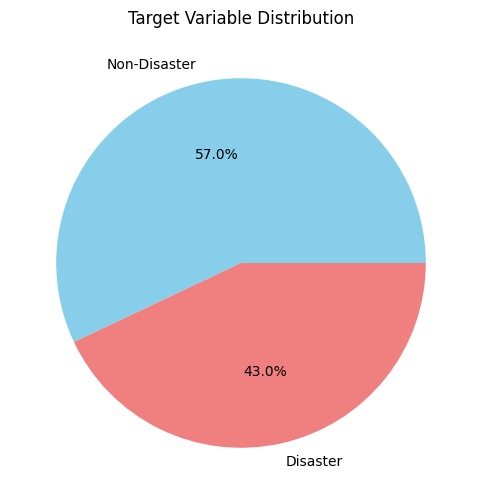

In [6]:
target_counts = raw_data['target'].value_counts()
print(f"Target distribution:")
print(f"Non-disaster (0): {target_counts[0]} ({target_counts[0]/len(raw_data)*100:.1f}%)")
print(f"Disaster (1): {target_counts[1]} ({target_counts[1]/len(raw_data)*100:.1f}%)")

plt.figure(figsize=(8, 6))
plt.pie(target_counts.values, labels=['Non-Disaster', 'Disaster'], 
        autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Target Variable Distribution')
plt.show()

There is a slight class imbalance, but it is not very storng. This likely won't need to be addressed.

## Features

### Word/character Counts

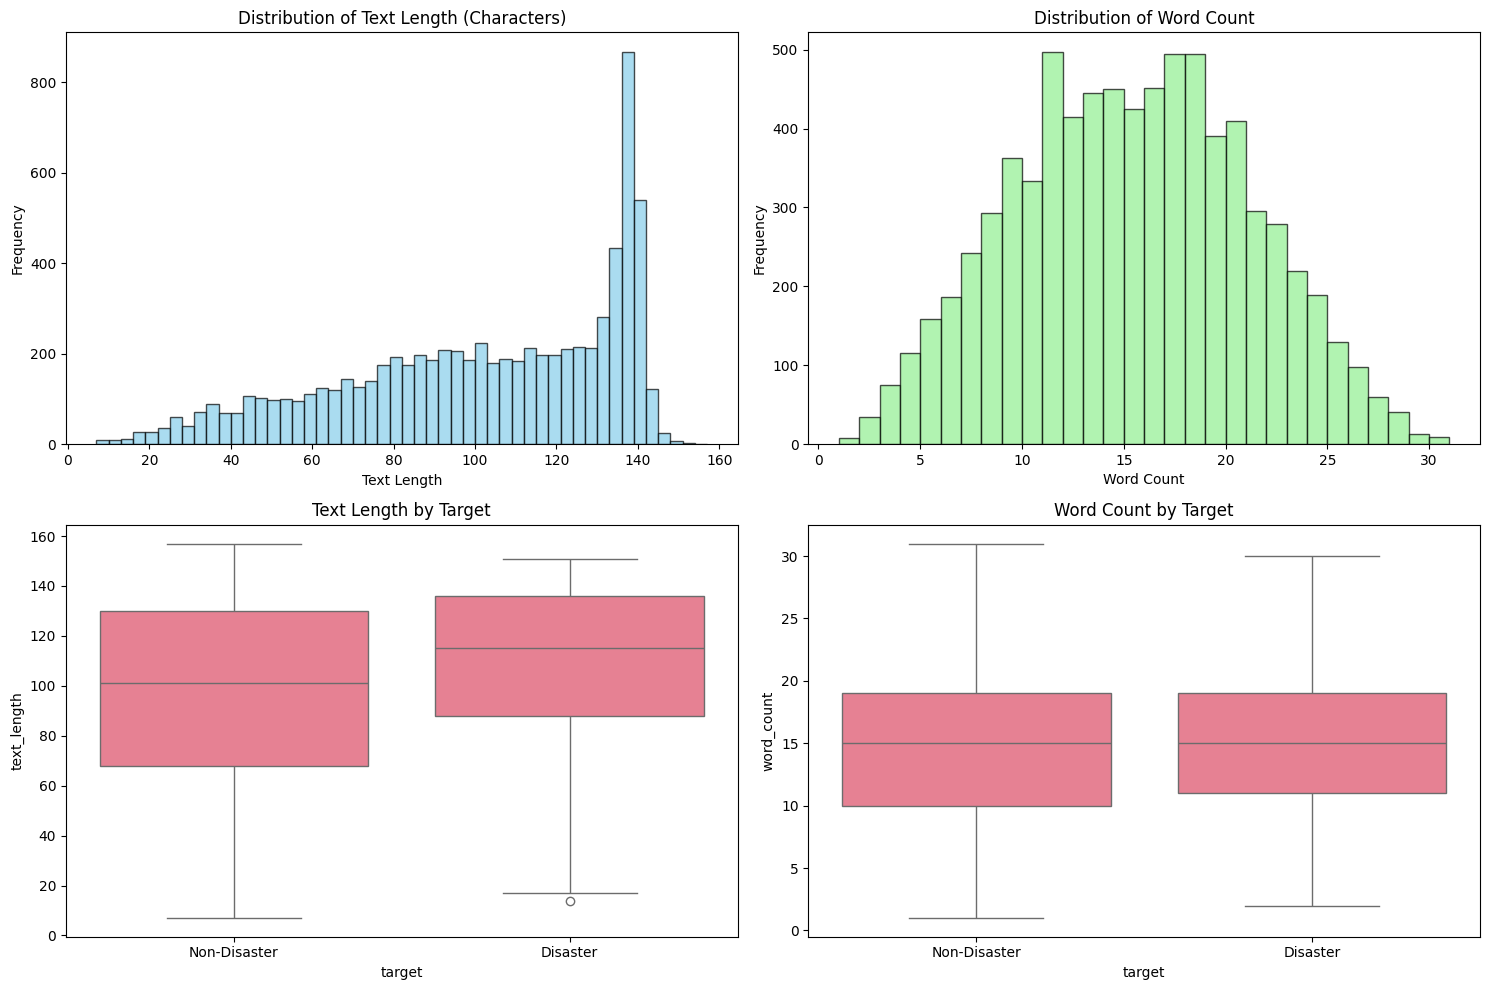


Text length comparison by target:
         count        mean        std   min   25%    50%    75%    max
target                                                                
0       4342.0   95.706817  35.885924   7.0  68.0  101.0  130.0  157.0
1       3271.0  108.113421  29.309854  14.0  88.0  115.0  136.0  151.0

Word count comparison by target:
         count       mean       std  min   25%   50%   75%   max
target                                                          
0       4342.0  14.704744  6.161564  1.0  10.0  15.0  19.0  31.0
1       3271.0  15.167533  5.096806  2.0  11.0  15.0  19.0  30.0


In [7]:
raw_data['text_length'] = raw_data['text'].apply(len)
raw_data['word_count'] = raw_data['text'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0,0].hist(raw_data['text_length'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribution of Text Length (Characters)')
axes[0,0].set_xlabel('Text Length')
axes[0,0].set_ylabel('Frequency')

axes[0,1].hist(raw_data['word_count'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Distribution of Word Count')
axes[0,1].set_xlabel('Word Count')
axes[0,1].set_ylabel('Frequency')

sns.boxplot(data=raw_data, x='target', y='text_length', ax=axes[1,0])
axes[1,0].set_title('Text Length by Target')
axes[1,0].set_xticklabels(['Non-Disaster', 'Disaster'])

sns.boxplot(data=raw_data, x='target', y='word_count', ax=axes[1,1])
axes[1,1].set_title('Word Count by Target')
axes[1,1].set_xticklabels(['Non-Disaster', 'Disaster'])

plt.tight_layout()
plt.show()

print(f"\nText length comparison by target:")
print(raw_data.groupby('target')['text_length'].describe())
print(f"\nWord count comparison by target:")
print(raw_data.groupby('target')['word_count'].describe())

raw_data = raw_data.drop(columns=['text_length', 'word_count'])

The text length varies from 7 - 157 characters, averaging at around 100. The word count ranges from 1 - 31 words, averaging around 15 words.

There is not a significant difference in word counts between disaster and non-disaster tweets, but disaster tweets tend to have slightly longer text length. This could potentially be a new feature to add to the dataset.

In [8]:
raw_data['keyword'] = raw_data['keyword'].str.replace('%20', ' ', regex=False)

I noticed that some keywords had a '%20' inside of them instead of a space. This is because of URL encodings, likely because the data was scraped from URLs. I made a quick edit to replace this with spaces.

### Keywords

Records without keywords: 61 (0.8%)


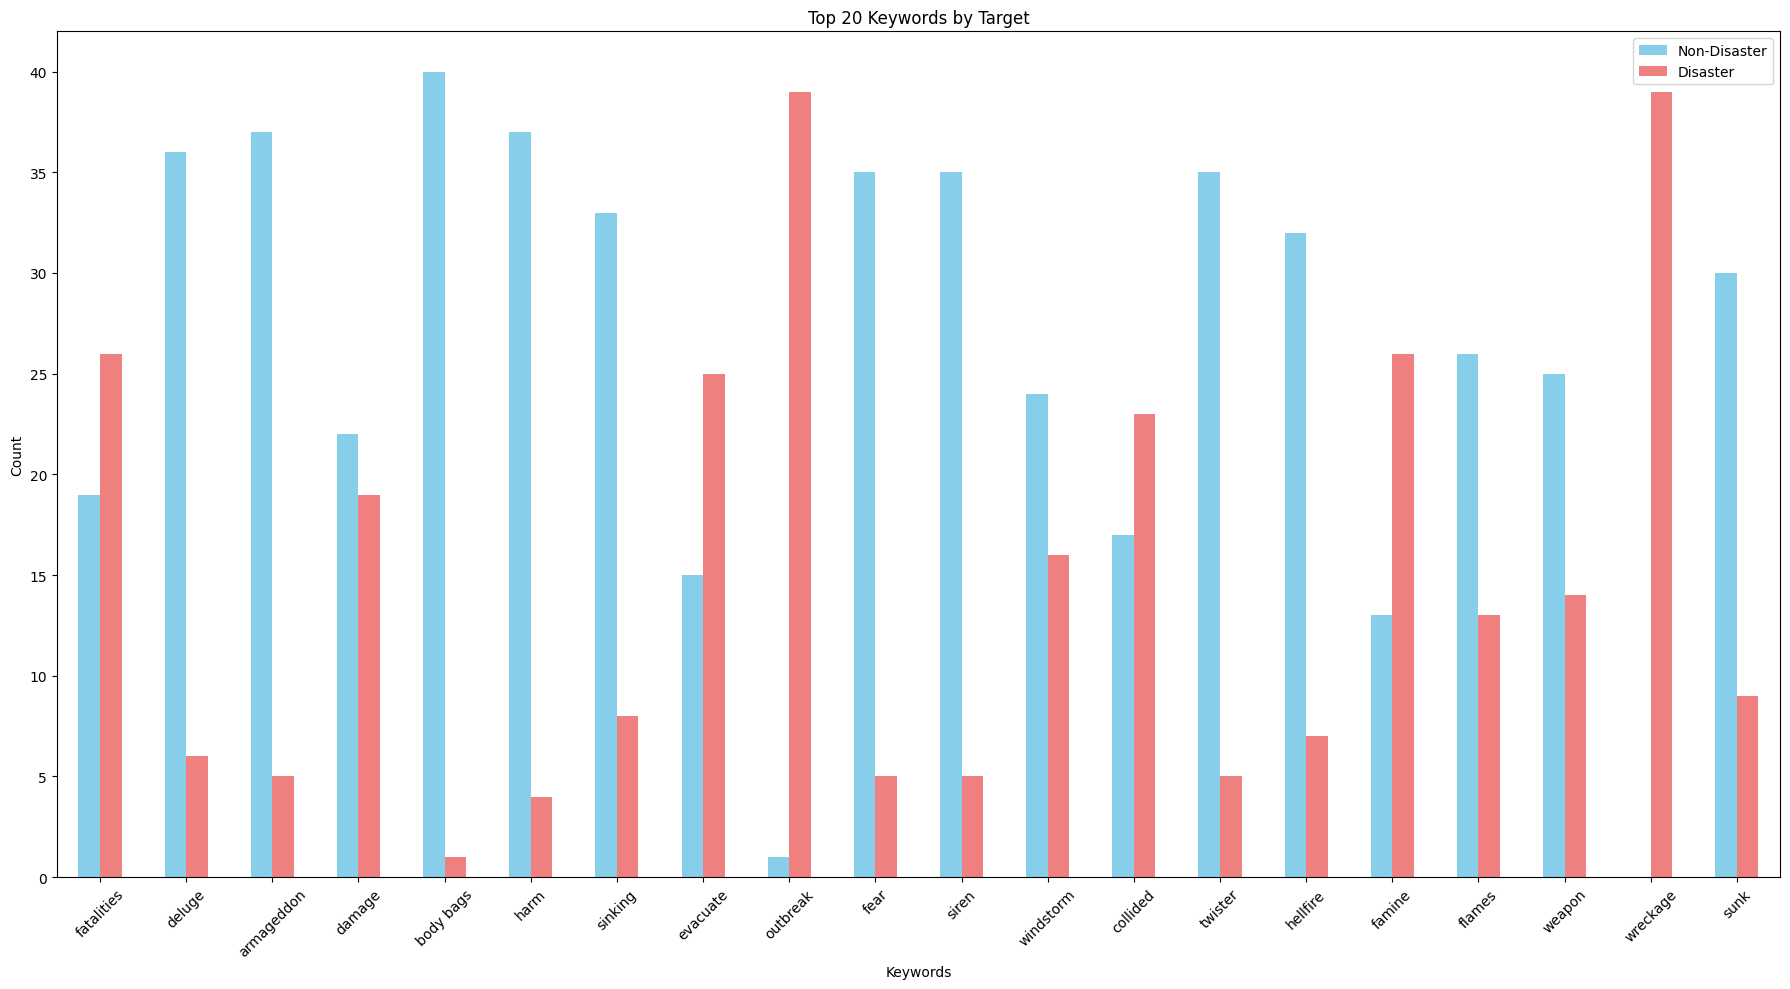

In [9]:
keywords_present = raw_data['keyword'].notna().sum()
total_records = len(raw_data)
print(f"Records without keywords: {total_records - keywords_present} ({(total_records - keywords_present)/total_records*100:.1f}%)")

keyword_counts = raw_data['keyword'].value_counts().head(20)
keyword_target = raw_data.groupby(['keyword', 'target']).size().unstack(fill_value=0)
keyword_target_top = keyword_target.loc[keyword_counts.index[:20]]

keyword_target_top.plot(kind='bar', figsize=(18, 10), color=['skyblue', 'lightcoral'])
plt.title('Top 20 Keywords by Target')
plt.xlabel('Keywords')
plt.ylabel('Count')
plt.legend(['Non-Disaster', 'Disaster'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The difference in frequencies for the top twenty keywords indicates that this will be a key feature in differentiating between the two classes. Since the amount of records with no keyword was so little (only 61), I decided to just fill it with blank strings, as that would help with keeping the tokenizer consistent in the preprocessing step.

In [10]:
raw_data['keyword'] = raw_data['keyword'].fillna('')

### Locations

Records without locations: 2533 (33.3%)

Percentage of tweets with locations:
Non-disaster: 66.4%
Disaster: 67.1%


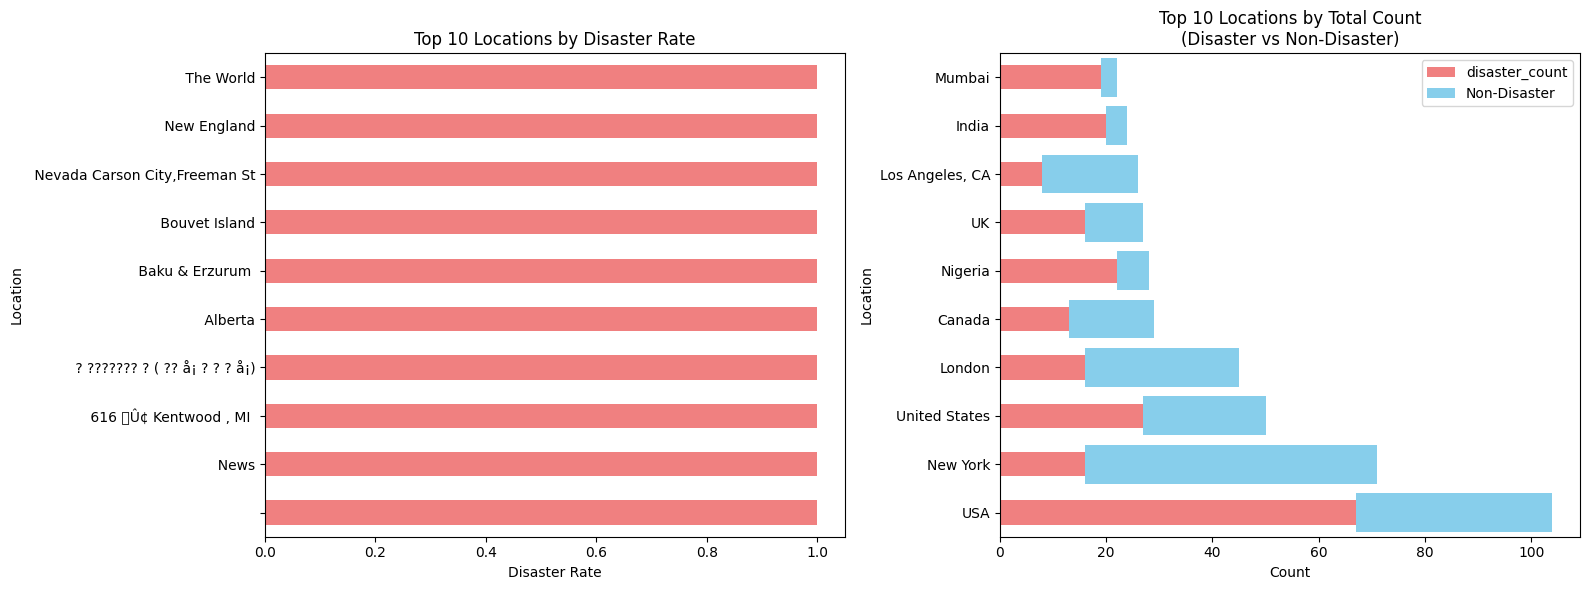

In [11]:
locations_present = raw_data['location'].notna().sum()
total_records = len(raw_data)
print(f"Records without locations: {total_records - locations_present} ({(total_records - locations_present)/total_records*100:.1f}%)")

location_by_target = raw_data.groupby('target')['location'].apply(lambda x: x.notna().sum())
total_by_target = raw_data['target'].value_counts()
location_pct_by_target = (location_by_target / total_by_target * 100)
print(f"\nPercentage of tweets with locations:")
print(f"Non-disaster: {location_pct_by_target[0]:.1f}%")
print(f"Disaster: {location_pct_by_target[1]:.1f}%")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

location_disaster_analysis = raw_data[raw_data['location'].notna()].groupby('location').agg({
    'target': ['count', 'sum', 'mean']
}).round(3)
location_disaster_analysis.columns = ['total_count', 'disaster_count', 'disaster_rate']

top_disaster_locations = location_disaster_analysis.nlargest(10, 'disaster_rate')
top_disaster_locations['disaster_rate'].plot(kind='barh', ax=axes[0], color='lightcoral')
axes[0].set_title('Top 10 Locations by Disaster Rate')
axes[0].set_xlabel('Disaster Rate')
axes[0].set_ylabel('Location')

top_locations_overall = location_disaster_analysis.nlargest(10, 'total_count')
top_locations_overall[['disaster_count']].plot(kind='barh', ax=axes[1], 
                                              color='lightcoral', label='Disaster')
non_disaster_count = top_locations_overall['total_count'] - top_locations_overall['disaster_count']
axes[1].barh(range(len(top_locations_overall)), non_disaster_count, 
               left=top_locations_overall['disaster_count'], color='skyblue', label='Non-Disaster')

axes[1].set_title('Top 10 Locations by Total Count\n(Disaster vs Non-Disaster)')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Location')
axes[1].legend()

plt.tight_layout()
plt.show()

In [12]:
unique_locations = raw_data['location'].nunique()
total_locations = raw_data['location'].notna().sum()
print(f"Number of unique locations: {unique_locations}")
print(f"Total records with location data: {total_locations}")
print(f"Percentage of unique locations: {unique_locations/total_locations*100:.2f}%")

Number of unique locations: 3341
Total records with location data: 5080
Percentage of unique locations: 65.77%


About 33% of the records had missing locations, evenly spread across the two classes. The locations are also user generated, which means that there is no standardization between locations. This is likely why there are so many unique locations (65%). 

Of the top locations, the percentage of disaster tweets varies a little, but not enough to be very significant. The highest frequency is only about 100.

The first plot also shows that the rate of disasters in locations can be 1 very frequently, especially because of how many unique locations there are.

Because of the dirtiness of this feature, I decided to remove it from the dataset.

In [13]:
train_data = raw_data.drop(columns=['location'])

In [14]:
#train_data['text_length'] = train_data['text'].apply(len)
#train_data['word_count'] = train_data['text'].apply(lambda x: len(x.split()))
train_data.head()

,id,keyword,text,target
0,1,,Our Deeds are the Reason of this #earthquake M...,1
1,4,,Forest fire near La Ronge Sask. Canada,1
2,5,,All residents asked to 'shelter in place' are ...,1
3,6,,"13,000 people receive #wildfires evacuation or...",1
4,7,,Just got sent this photo from Ruby #Alaska as ...,1


### Cleaning and Engineering Summary So Far:

- removed location feature
- cleaned some URL encodings (will be expanded on below)
- filled missing keywords with empty strings

## Preprocessing

In order to keep the RNN model simple and using sequential text data, I ended up only using the text features of each tweet (even after all that cleaning/exploration).

RNNs are specialized for sequential data, like sentences or tweets. The keyword feature would add some extra non-sequential data that would require a much more complicated architecture to handle.

I first needed to do some basic text cleaning, such as dealing with URLs, hashtags, etc.

> !!! detailed cleaning description

In [15]:
def clean_text(text):
    text = re.sub(r'http\S+', 'url', text)
    text = re.sub(r'#(\w+)', r' hashtag \1 ', text)
    text = re.sub(r'@(\w+)', r' mention \1 ', text)
    text = re.sub(r'[^a-zA-Z0-9\s!?.]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [16]:
print("#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires")
print(f"Cleaned: {clean_text('#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires')}")

#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
Cleaned: hashtag RockyFire Update California Hwy. 20 closed in both directions due to Lake County fire hashtag CAfire hashtag wildfires


In [17]:
test_data = pd.read_csv('./data/test.csv')
test_data['keyword'] = test_data['keyword'].fillna('')

train_data['text_clean'] = train_data['text'].apply(clean_text)
test_data['text_clean'] = test_data['text'].apply(clean_text)

I then used Keras's basic Tokenizer to tokenize the data. This tokenizer just assigns an index to each word. It's very basic, but it allows for the text data to remain in order without becoming a giant sparse matrix of tokenized words.

In [18]:
MAX_VOCAB_SIZE = 30000  # maximum vocabulary size
MAX_SEQUENCE_LENGTH = 50  # maximum tweet length

# Create tokenizer for text
text_tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    oov_token="<OOV>",
    lower=True
)

all_texts = list(train_data['text_clean']) + list(test_data['text_clean'])
#all_texts = list(train_data['text']) + list(test_data['text'])
text_tokenizer.fit_on_texts(all_texts)

train_text_sequences = text_tokenizer.texts_to_sequences(train_data['text_clean'])
test_text_sequences = text_tokenizer.texts_to_sequences(test_data['text_clean'])
# padding sequences to same length
X_train_seq = pad_sequences(train_text_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_seq = pad_sequences(test_text_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

In [19]:
print(f"Vocab size: {len(text_tokenizer.word_index)}")

Vocab size: 22125


In [20]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_seq, train_data['target'].values, test_size=0.2, random_state=42, stratify=train_data['target'].values
)

### Metrics Plan

f1 score

***
# Modelling
***

approach involved trying 3 types of RNN architectures. 

used simple rnn for a baseline, with minimal/no tuning.

each model started with two rnn layers, batch normalization (and why) into 1 dense layer followed by output layer.  
- reasoning for this

base hparams i started with

early stopping patience, warm up time

In [21]:
LEARNING_RATE = 0.0001
METRICS = ['accuracy', 'Precision', 'Recall', 'AUC']
EMB_DIM = 128
BATCH_SIZE = 32

#### Functions

In [29]:
early_stopping_rnn = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1,
    start_from_epoch=7
)

vocab_size = min(MAX_VOCAB_SIZE, len(text_tokenizer.word_index)) + 1

def compile_fit(model):
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=METRICS
    )

    return model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping_rnn],
        verbose=1
    ).history

In [9]:
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    epochs = range(1, len(history['loss']) + 1)
    
    # loss
    axes[0, 0].plot(epochs, history['loss'], label='Training Loss', color='blue', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], label='Validation Loss', color='red', linewidth=2)
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_xticks(epochs)
    
    # accuracy
    axes[0, 1].plot(epochs, history['accuracy'], label='Training Accuracy', color='blue', linewidth=2)
    axes[0, 1].plot(epochs, history['val_accuracy'], label='Validation Accuracy', color='red', linewidth=2)
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xticks(epochs)
    
    # f1 score
    train_precision = np.array(history['Precision'])
    train_recall = np.array(history['Recall'])
    val_precision = np.array(history['val_Precision'])
    val_recall = np.array(history['val_Recall'])
    train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall + 1e-7) # prevents division by zero
    val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall + 1e-7)
    
    axes[1, 0].plot(epochs, train_f1, label='Training F1 Score', color='blue', linewidth=2)
    axes[1, 0].plot(epochs, val_f1, label='Validation F1 Score', color='red', linewidth=2)
    axes[1, 0].set_title('Model F1 Score')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xticks(epochs)
    
    # AUC-ROC
    axes[1, 1].plot(epochs, history['AUC'], label='Training AUC', color='blue', linewidth=2)
    axes[1, 1].plot(epochs, history['val_AUC'], label='Validation AUC', color='red', linewidth=2)
    axes[1, 1].set_title('Model AUC-ROC')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('AUC')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xticks(epochs)
    
    plt.tight_layout()
    plt.show()

    print(f"Learning Rate: {LEARNING_RATE}")
    print(f"Embedding Dimension: {EMB_DIM}")
    print(f"Batch Size: {BATCH_SIZE}")

    print("\nResults:")
    print(f"Loss: {history['val_loss'][-1]:.4f}")
    print(f"Accuracy: {history['val_accuracy'][-1]:.4f}")
    print(f"Training F1 Score: {train_f1[-1]:.4f}")
    print(f"Validation F1 Score: {val_f1[-1]:.4f}")

## SimpleRNN

description

In [167]:
rnn1 = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH, name='text_embedding'),
    
    SimpleRNN(64, recurrent_dropout=0.1, return_sequences=True, name='rnn_1'),
    SimpleRNN(32, recurrent_dropout=0.1, return_sequences=False, name='rnn_2'),
    BatchNormalization(),
    
    Dense(32, activation='relu', name='dense_1'),
    Dropout(0.1, name='dropout_1'),
    Dense(1, activation='sigmoid', name='output')
])

hist_rnn1 = compile_fit(rnn1)

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - AUC: 0.4946 - Precision: 0.4257 - Recall: 0.4161 - accuracy: 0.5079 - loss: 0.7619 - val_AUC: 0.5257 - val_Precision: 0.4000 - val_Recall: 0.0092 - val_accuracy: 0.5686 - val_loss: 0.6838
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - AUC: 0.4946 - Precision: 0.4257 - Recall: 0.4161 - accuracy: 0.5079 - loss: 0.7619 - val_AUC: 0.5257 - val_Precision: 0.4000 - val_Recall: 0.0092 - val_accuracy: 0.5686 - val_loss: 0.6838
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - AUC: 0.4876 - Precision: 0.4199 - Recall: 0.3347 - accuracy: 0.5154 - loss: 0.7374 - val_AUC: 0.5334 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6862
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - AUC: 0.4876 - Precision: 0.4199 - Recall: 0.3347 - accuracy: 0.5154 - loss: 0.7374 - val_AUC: 0.5334 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6862
Epoch 3/50
1

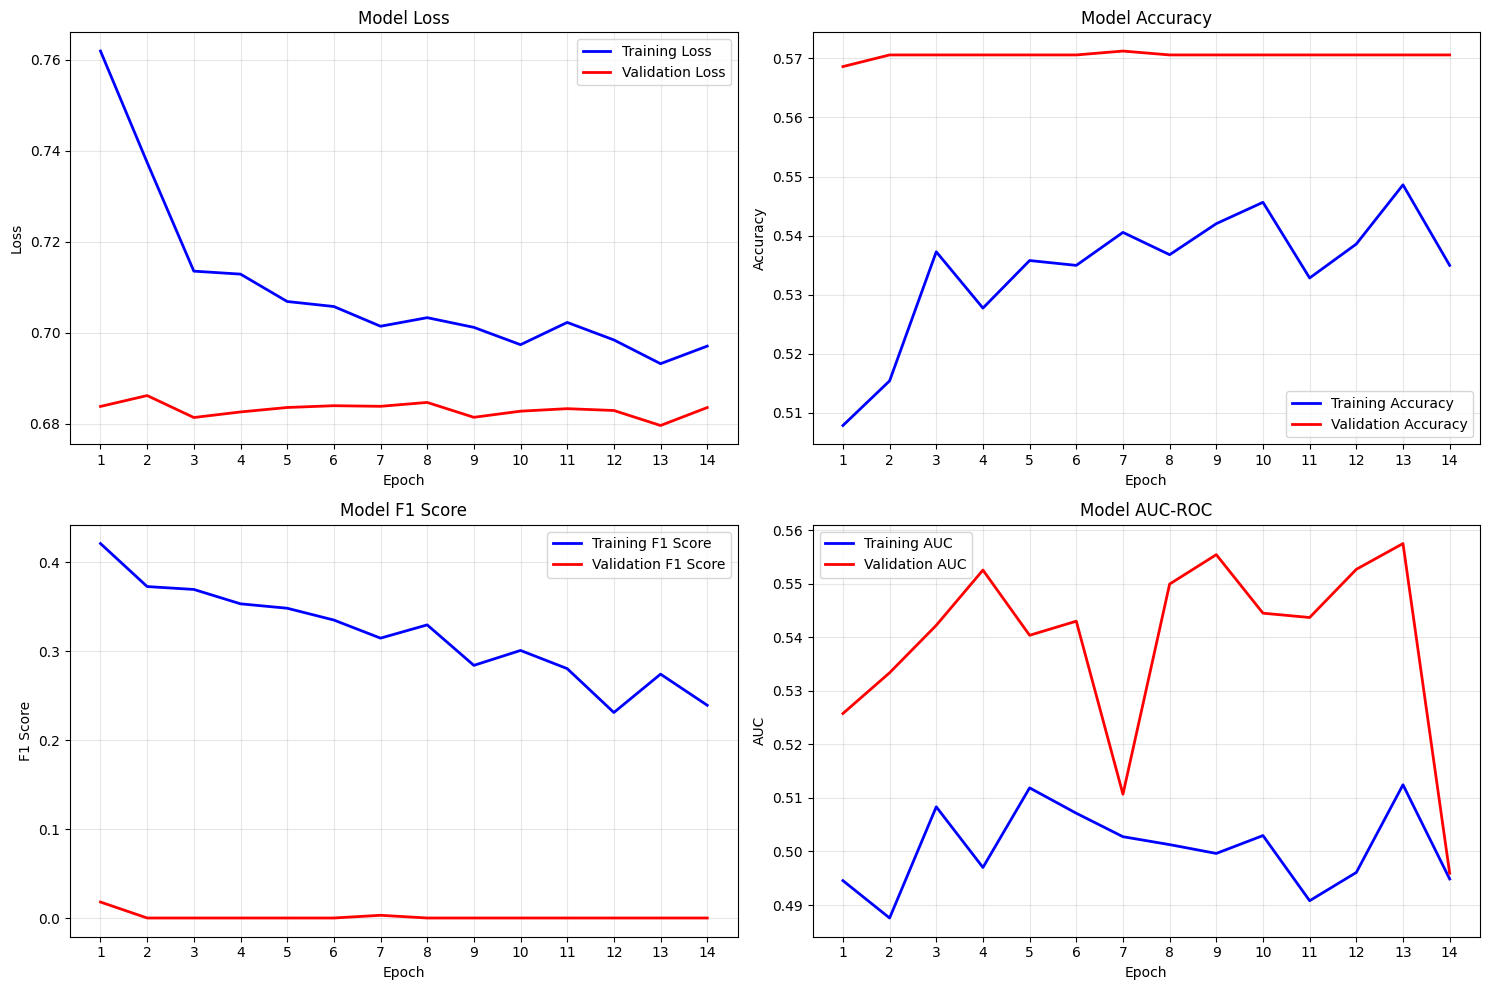

Learning Rate: 0.0001
Embedding Dimension: 128
Batch Size: 32

Results:
Loss: 0.6835
Accuracy: 0.5706
Training F1 Score: 0.2391
Validation F1 Score: 0.0000


In [168]:
plot_training_history(hist_rnn1)

poor performance, vanishing gradients?

basically just guessing, similar ratio to class sizes

did so bad and i didn't have high hopes so i didn't bother tuning it

## LSTM

description

In [170]:
LEARNING_RATE = 0.0001
EMB_DIM = 128
BATCH_SIZE = 32

lstm1 = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    LSTM(64, recurrent_dropout=0.1, return_sequences=True, name='lstm_1'),
    LSTM(32, recurrent_dropout=0.1, name='lstm_2'),
    BatchNormalization(),
    
    Dense(32, activation='relu', name='dense_1'),
    Dropout(0.1, name='dropout_1'),
    Dense(1, activation='sigmoid', name='output')
])

hist_lstm1 = compile_fit(lstm1)

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - AUC: 0.5085 - Precision: 0.4417 - Recall: 0.4257 - accuracy: 0.5220 - loss: 0.6932 - val_AUC: 0.5000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6895
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - AUC: 0.5085 - Precision: 0.4417 - Recall: 0.4257 - accuracy: 0.5220 - loss: 0.6932 - val_AUC: 0.5000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6895
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5956 - Precision: 0.5180 - Recall: 0.3019 - accuracy: 0.5793 - loss: 0.6669 - val_AUC: 0.8139 - val_Precision: 0.7410 - val_Recall: 0.6300 - val_accuracy: 0.7466 - val_loss: 0.6002
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5956 - Precision: 0.5180 - Recall: 0.3019 - accuracy: 0.5793 - loss: 0.6669 - val_AUC: 0.8139 - val_Precision: 0.7410 - val_Recall: 0.6300 - val_accuracy: 0.7466 - val_loss: 0.6002
Epoch 3/50

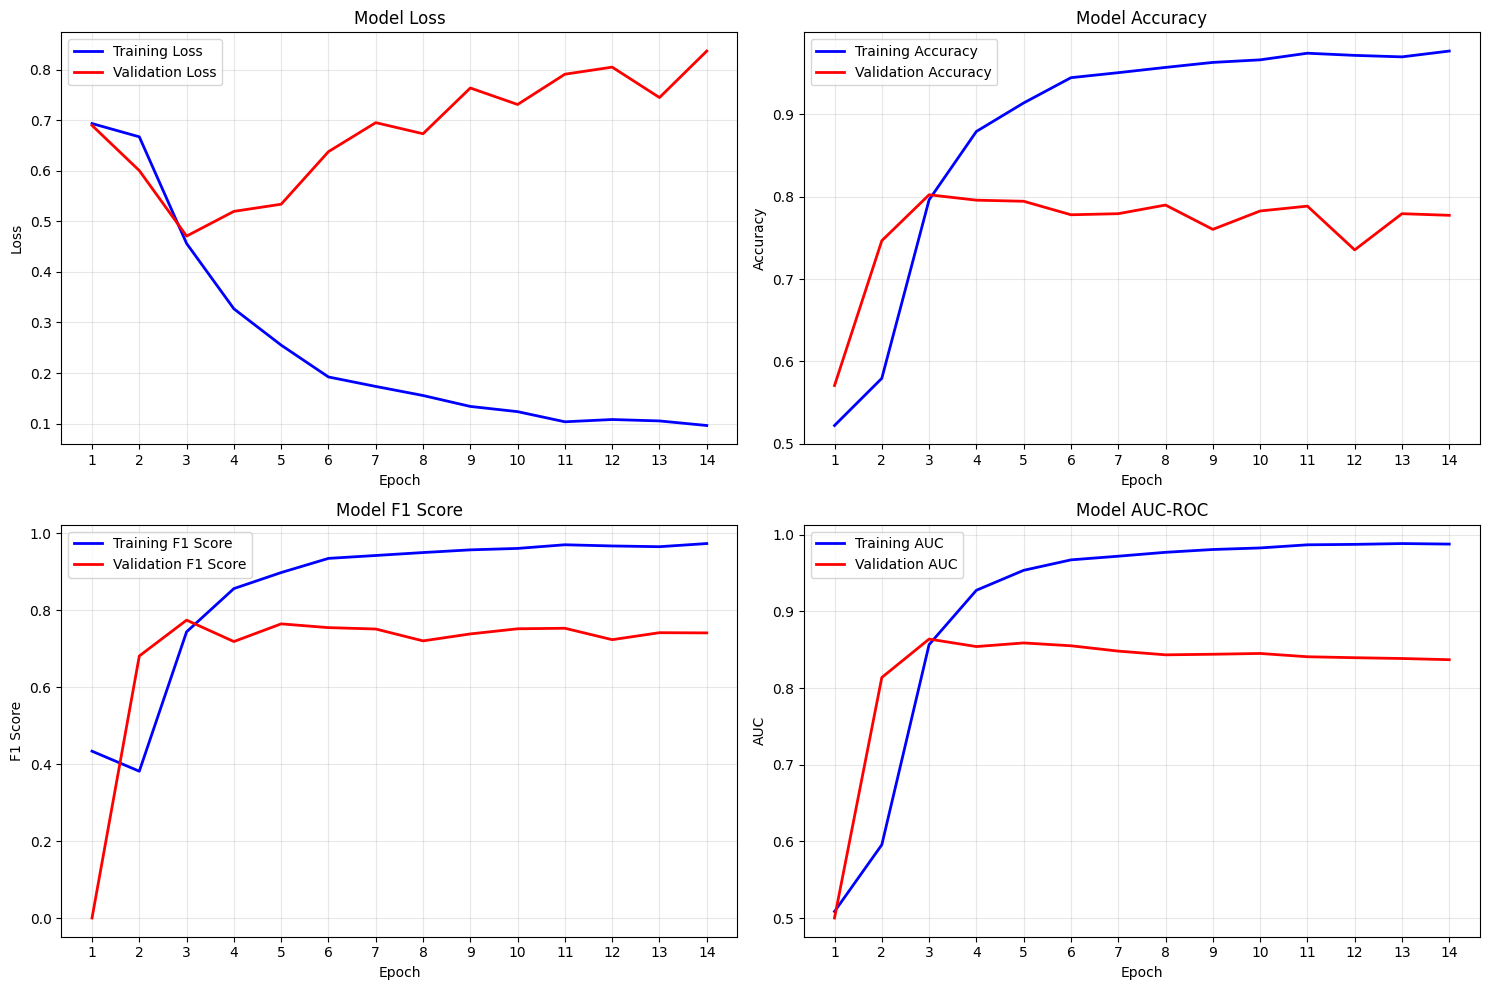

Learning Rate: 0.0001
Embedding Dimension: 128
Batch Size: 32

Results:
Loss: 0.8365
Accuracy: 0.7774
Training F1 Score: 0.9732
Validation F1 Score: 0.7410


In [171]:
plot_training_history(hist_lstm1)

massive overfitting after epoch 3

more dropout?

In [172]:
LEARNING_RATE = 0.0001
EMB_DIM = 128
BATCH_SIZE = 32

lstm2 = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    LSTM(64, recurrent_dropout=0.2, return_sequences=True, name='lstm_1'),
    LSTM(32, dropout=0.2, recurrent_dropout=0.2, name='lstm_2'),
    BatchNormalization(),
    
    Dense(32, activation='relu', name='dense_1'),
    Dropout(0.2, name='dropout_1'),
    Dense(1, activation='sigmoid', name='output')
])

hist_lstm2 = compile_fit(lstm2)

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - AUC: 0.4947 - Precision: 0.4218 - Recall: 0.5071 - accuracy: 0.4895 - loss: 0.7067 - val_AUC: 0.5000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6895
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - AUC: 0.4947 - Precision: 0.4218 - Recall: 0.5071 - accuracy: 0.4895 - loss: 0.7067 - val_AUC: 0.5000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6895
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - AUC: 0.5040 - Precision: 0.4326 - Recall: 0.2831 - accuracy: 0.5323 - loss: 0.6910 - val_AUC: 0.5248 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6867
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - AUC: 0.5040 - Precision: 0.4326 - Recall: 0.2831 - accuracy: 0.5323 - loss: 0.6910 - val_AUC: 0.5248 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0

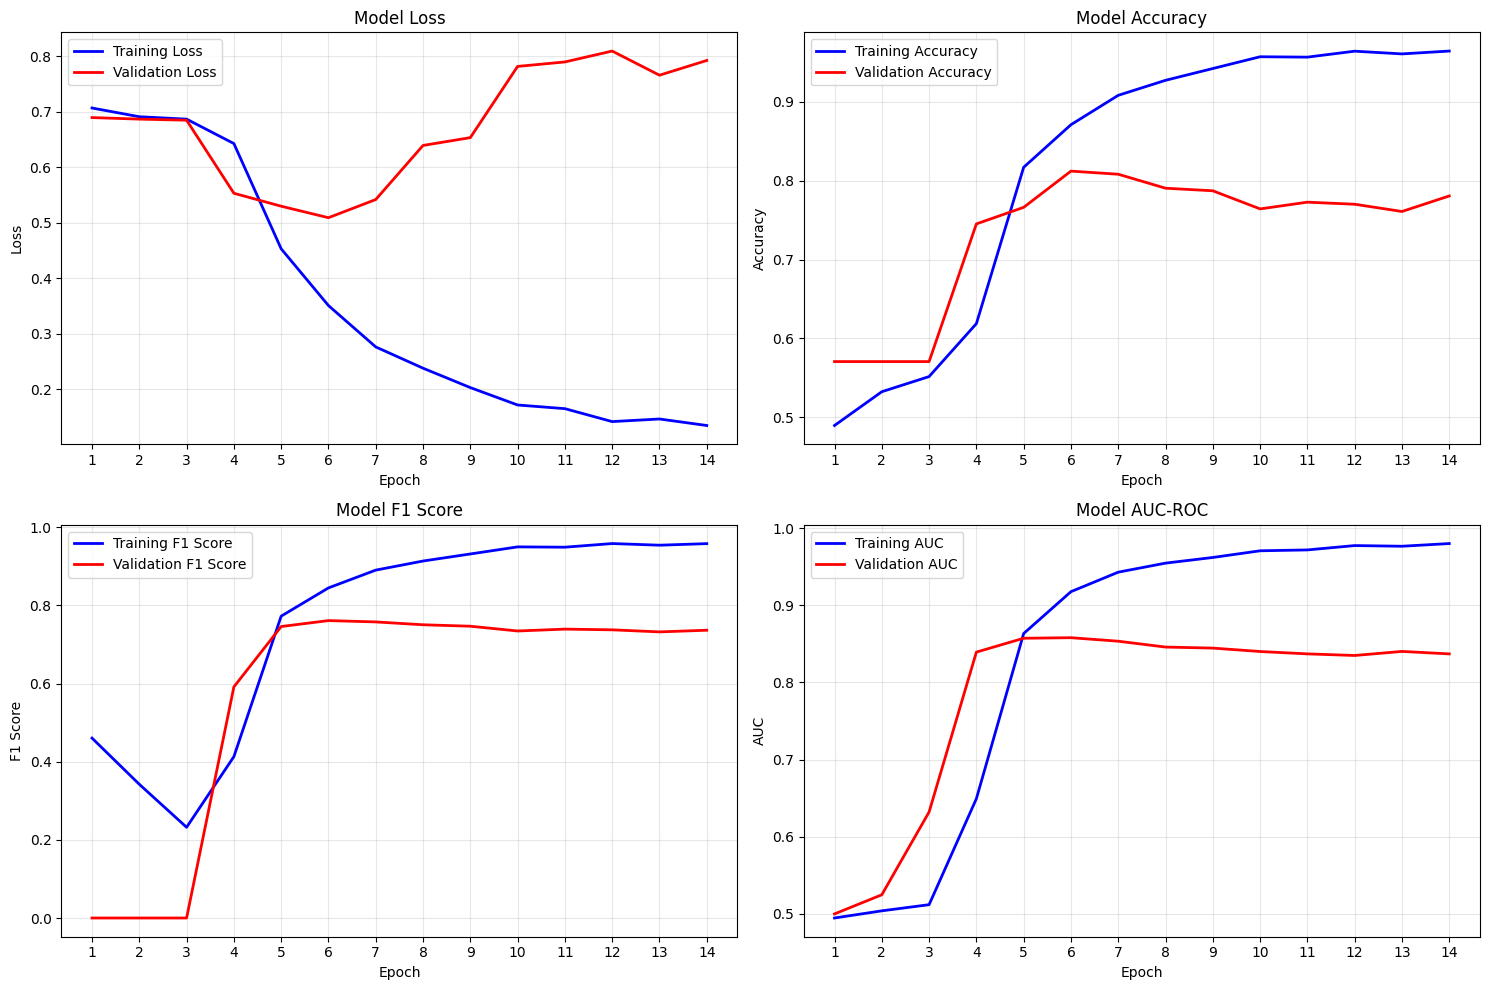

Learning Rate: 0.0001
Embedding Dimension: 128
Batch Size: 32

Results:
Loss: 0.7923
Accuracy: 0.7807
Training F1 Score: 0.9583
Validation F1 Score: 0.7366


In [173]:
plot_training_history(hist_lstm2)

still overfitting

l2 regularization?

> !!! rewrite

2. **LSTM layers**: Added both:
   - `kernel_regularizer=l2(0.01)` - regularizes the input-to-hidden weights
   - `recurrent_regularizer=l2(0.01)` - regularizes the hidden-to-hidden weights

3. **Dense layer**: Added `kernel_regularizer=l2(0.01)` to the dense layer

**What L2 regularization does:**
- Adds a penalty term to the loss function proportional to the square of the weights
- Encourages smaller weights, which helps prevent overfitting
- The `0.01` is the regularization strength (lambda) - you can adjust this value:
  - Higher values (e.g., 0.1) = stronger regularization = more penalty on large weights
  - Lower values (e.g., 0.001) = weaker regularization = less penalty

**Common L2 regularization values to try:**
- `0.001` - light regularization
- `0.01` - moderate regularization (what I used)
- `0.1` - strong regularization

You can experiment with different values if the overfitting persists. Start with `0.01` and increase if you still see overfitting, or decrease if the model starts underfitting.

Made changes.

In [ ]:
LEARNING_RATE = 0.0001
EMB_DIM = 128
BATCH_SIZE = 32

lstm3 = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    LSTM(64, recurrent_dropout=0.2, return_sequences=True, 
         kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001), name='lstm_1'),
    LSTM(32, dropout=0.2, recurrent_dropout=0.2, name='lstm_2'),
    BatchNormalization(),
    
    Dense(32, activation='relu', kernel_regularizer=l2(0.001), name='dense_1'),
    Dropout(0.2, name='dropout_1'),
    Dense(1, activation='sigmoid', name='output')
])

hist_lstm3 = compile_fit(lstm3)

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - AUC: 0.4897 - Precision: 0.4224 - Recall: 0.6263 - accuracy: 0.4714 - loss: 0.9400 - val_AUC: 0.5000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.8914
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - AUC: 0.4897 - Precision: 0.4224 - Recall: 0.6263 - accuracy: 0.4714 - loss: 0.9400 - val_AUC: 0.5000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.8914
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5071 - Precision: 0.4310 - Recall: 0.3531 - accuracy: 0.5217 - loss: 0.8686 - val_AUC: 0.5122 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.8446
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5071 - Precision: 0.4310 - Recall: 0.3531 - accuracy: 0.5217 - loss: 0.8686 - val_AUC: 0.5122 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0

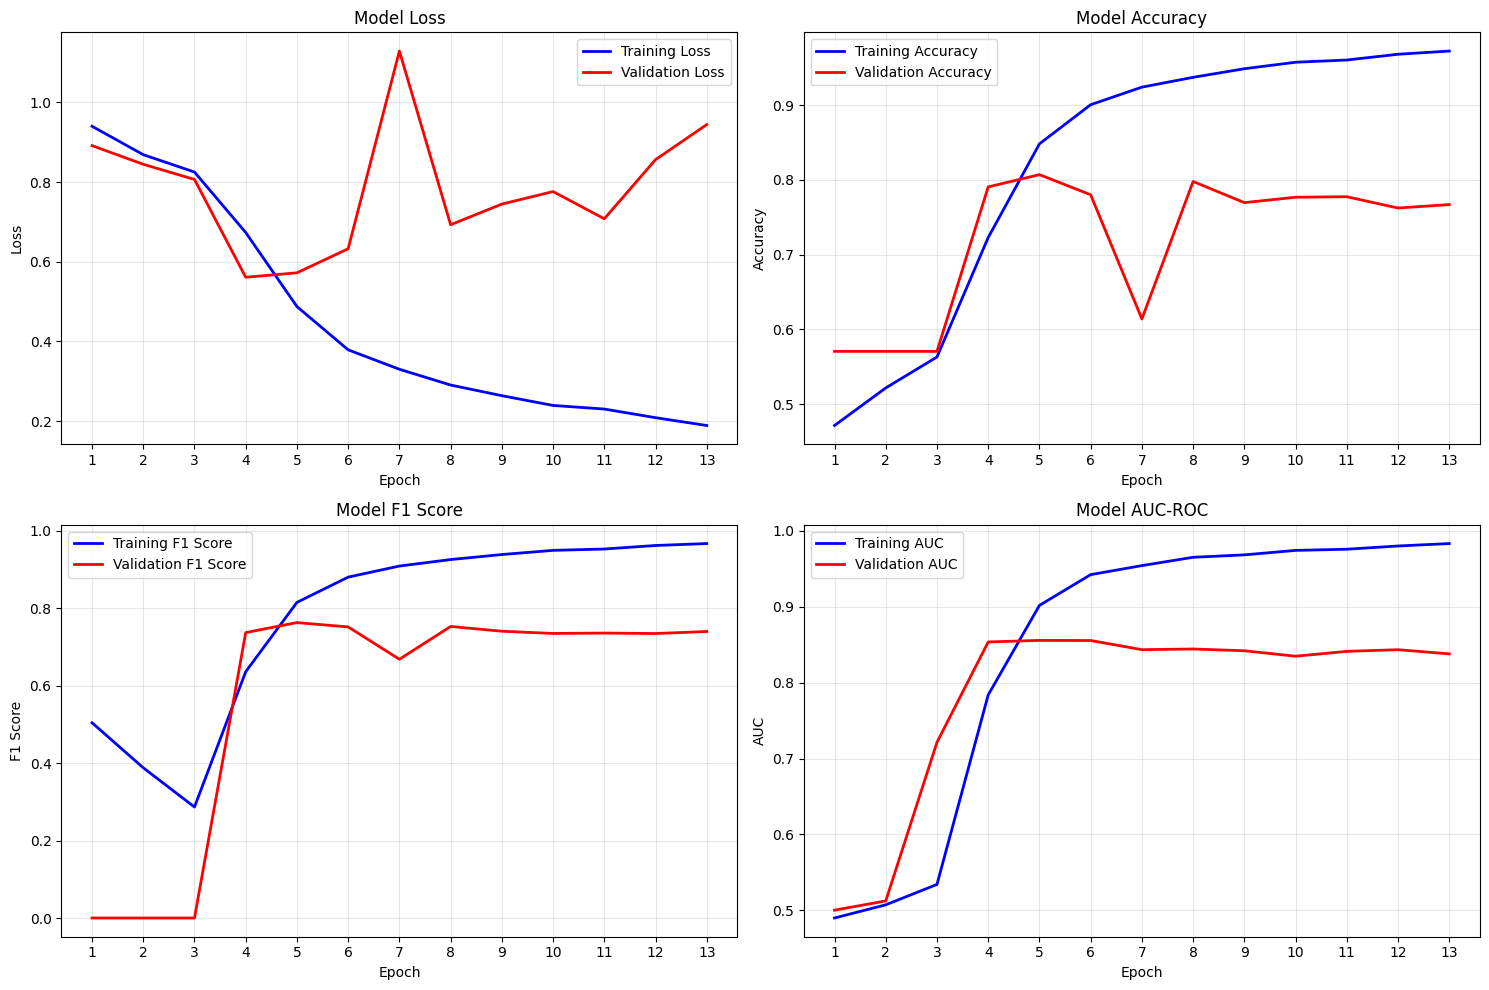

Learning Rate: 0.0001
Embedding Dimension: 128
Batch Size: 32

Results:
Loss: 0.9442
Accuracy: 0.7669
Training F1 Score: 0.9675
Validation F1 Score: 0.7403


In [176]:
plot_training_history(hist_lstm3)

## blstm

description

In [177]:
LEARNING_RATE = 0.0001
EMB_DIM = 128
BATCH_SIZE = 32

blstm1 = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.1), name='blstm'),

    Dense(32, activation='relu', name='dense_2'),
    Dropout(0.2, name='dropout_2'),
    Dense(1, activation='sigmoid', name='output')
])

hist_blstm1 = compile_fit(blstm1)

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - AUC: 0.5462 - Precision: 0.4507 - Recall: 0.0856 - accuracy: 0.5622 - loss: 0.6817 - val_AUC: 0.7269 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6659
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - AUC: 0.5462 - Precision: 0.4507 - Recall: 0.0856 - accuracy: 0.5622 - loss: 0.6817 - val_AUC: 0.7269 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6659
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - AUC: 0.7654 - Precision: 0.7917 - Recall: 0.4154 - accuracy: 0.7018 - loss: 0.6001 - val_AUC: 0.8259 - val_Precision: 0.7840 - val_Recall: 0.6162 - val_accuracy: 0.7623 - val_loss: 0.5207
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - AUC: 0.7654 - Precision: 0.7917 - Recall: 0.4154 - accuracy: 0.7018 - loss: 0.6001 - val_AUC: 0.8259 - val_Precision: 0.7840 - val_Recall: 0.6162 - val_accuracy: 0.7623 - val_loss: 0.5207
Epoch 3/50

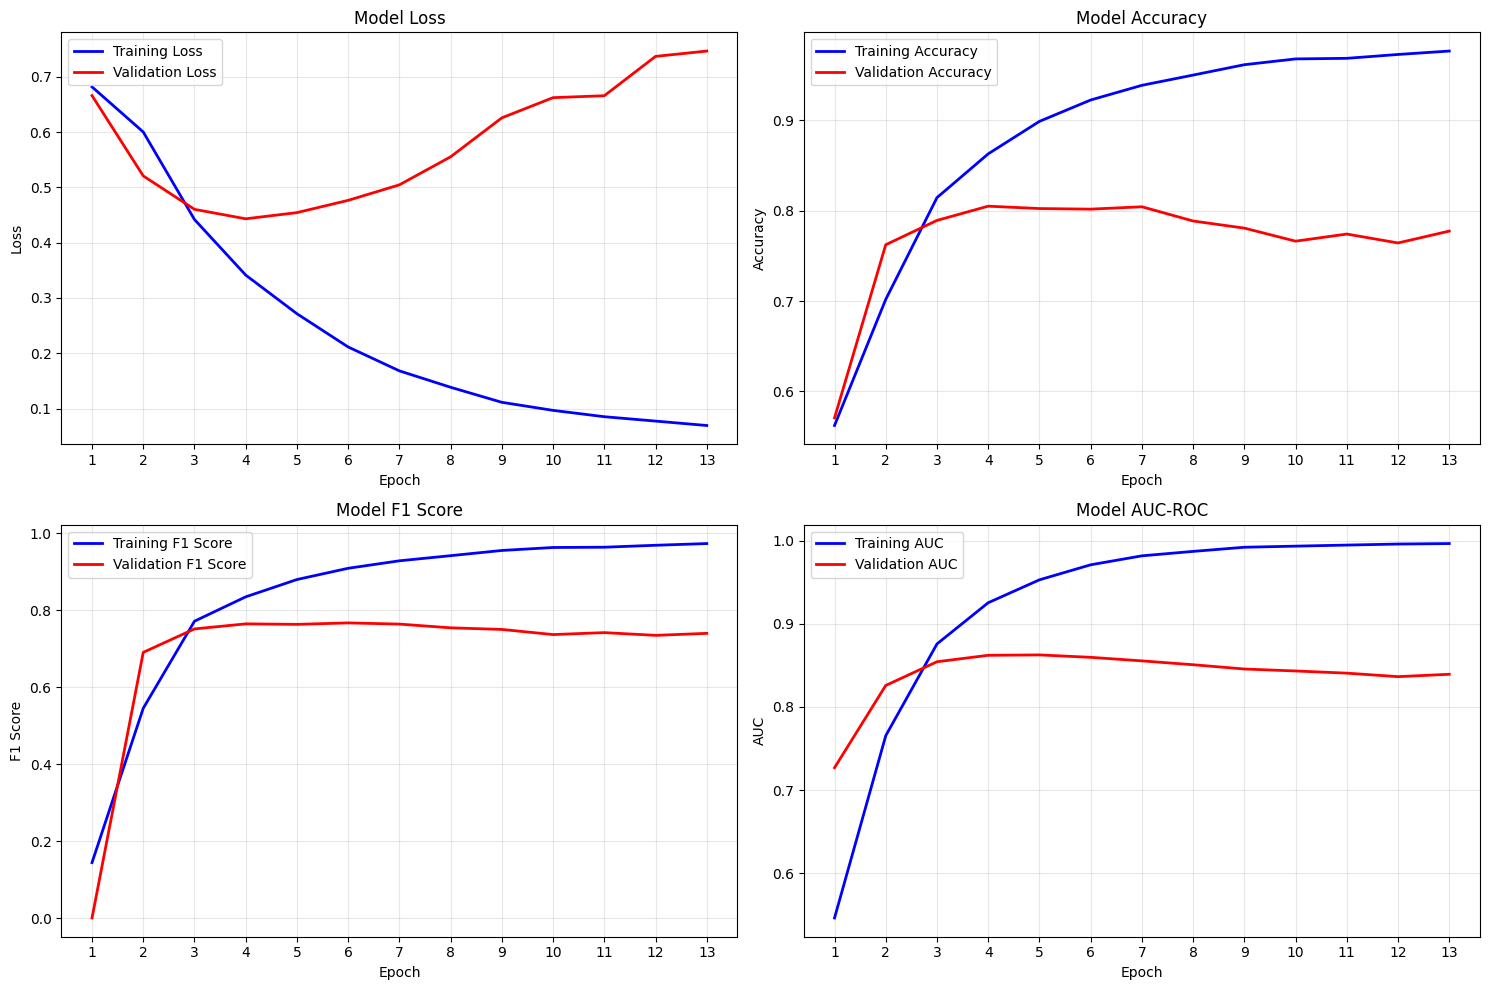

Learning Rate: 0.0001
Embedding Dimension: 128
Batch Size: 32

Results:
Loss: 0.7464
Accuracy: 0.7774
Training F1 Score: 0.9727
Validation F1 Score: 0.7394


In [180]:
plot_training_history(hist_blstm1)

overfitting again

lower learning rate

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - AUC: 0.5196 - Precision: 0.4218 - Recall: 0.1360 - accuracy: 0.5486 - loss: 0.7366 - val_AUC: 0.6897 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7273
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - AUC: 0.5196 - Precision: 0.4218 - Recall: 0.1360 - accuracy: 0.5486 - loss: 0.7366 - val_AUC: 0.6897 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7273
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - AUC: 0.6396 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.7178 - val_AUC: 0.7387 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7051
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - AUC: 0.6396 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.7178 - val_AUC: 0.7387 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.57

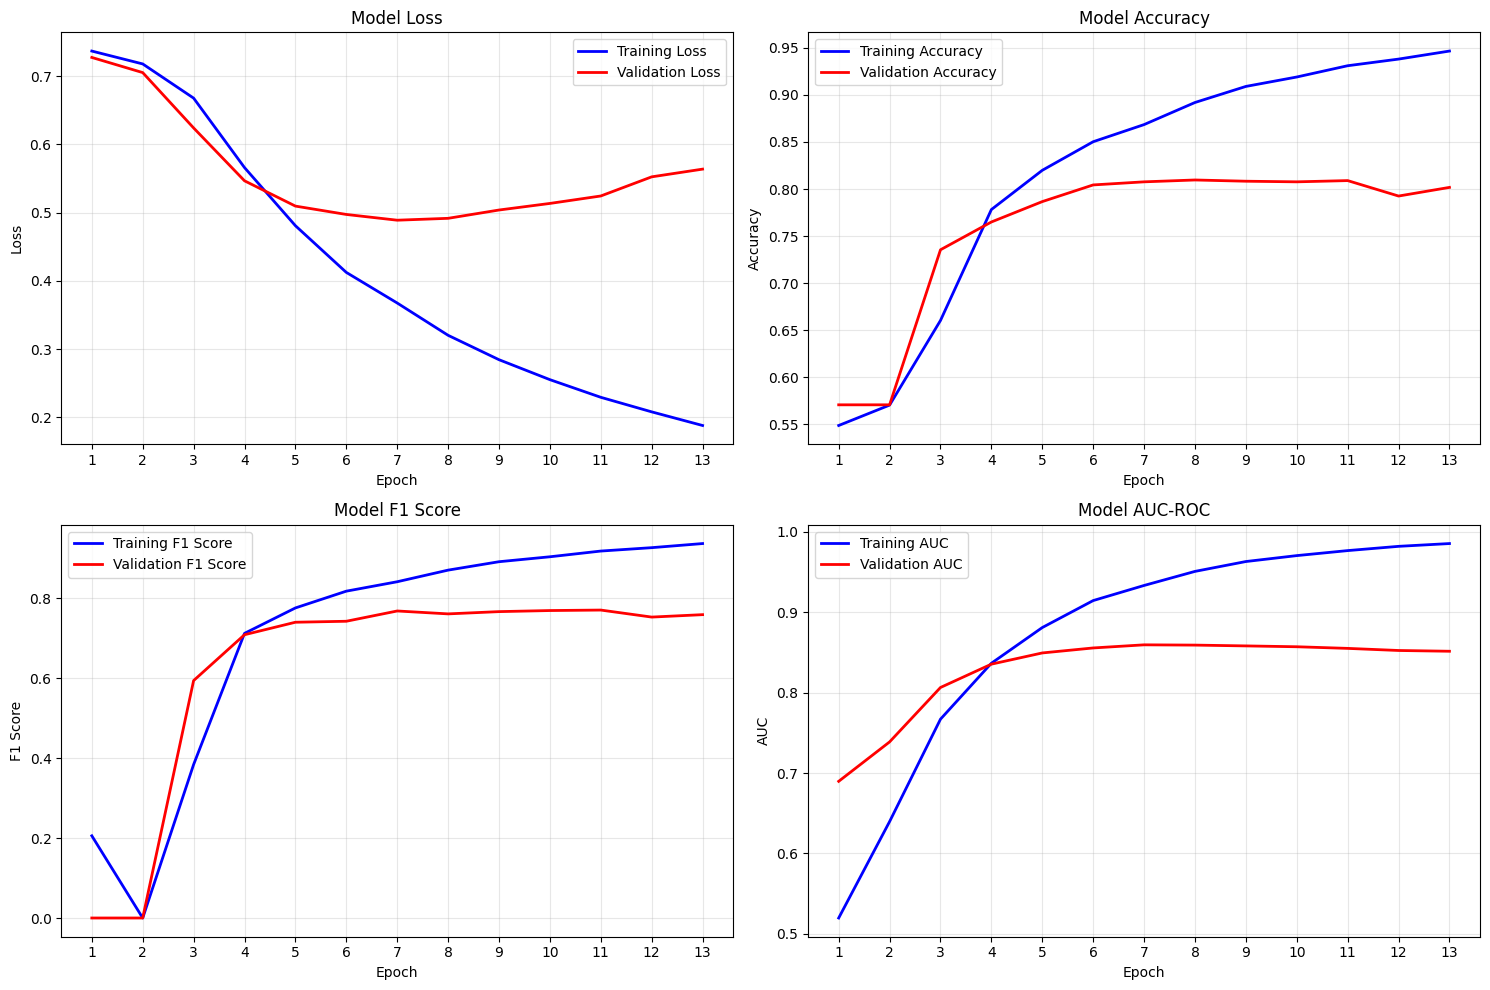

Learning Rate: 5e-05
Embedding Dimension: 128
Batch Size: 32

Results:
Loss: 0.5636
Accuracy: 0.8017
Training F1 Score: 0.9371
Validation F1 Score: 0.7592


In [183]:
LEARNING_RATE = 0.00005
EMB_DIM = 128
BATCH_SIZE = 32

blstm2 = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.1), name='blstm'),

    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2, name='dropout_2'),
    Dense(1, activation='sigmoid', name='output')
])

hist_blstm2 = compile_fit(blstm2)
plot_training_history(hist_blstm2)

slightly better 

higher emb dim

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - AUC: 0.5361 - Precision: 0.4091 - Recall: 0.0103 - accuracy: 0.5683 - loss: 0.7322 - val_AUC: 0.6728 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7234
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - AUC: 0.5361 - Precision: 0.4091 - Recall: 0.0103 - accuracy: 0.5683 - loss: 0.7322 - val_AUC: 0.6728 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7234
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - AUC: 0.6732 - Precision: 0.9048 - Recall: 0.0290 - accuracy: 0.5814 - loss: 0.7093 - val_AUC: 0.7560 - val_Precision: 0.9655 - val_Recall: 0.1284 - val_accuracy: 0.6238 - val_loss: 0.6893
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - AUC: 0.6732 - Precision: 0.9048 - Recall: 0.0290 - accuracy: 0.5814 - loss: 0.7093 - val_AUC: 0.7560 - val_Precision: 0.9655 - val_Recall: 0.1284 - val_accuracy: 0.6238 - val_loss: 0.6893
Epoch 3/

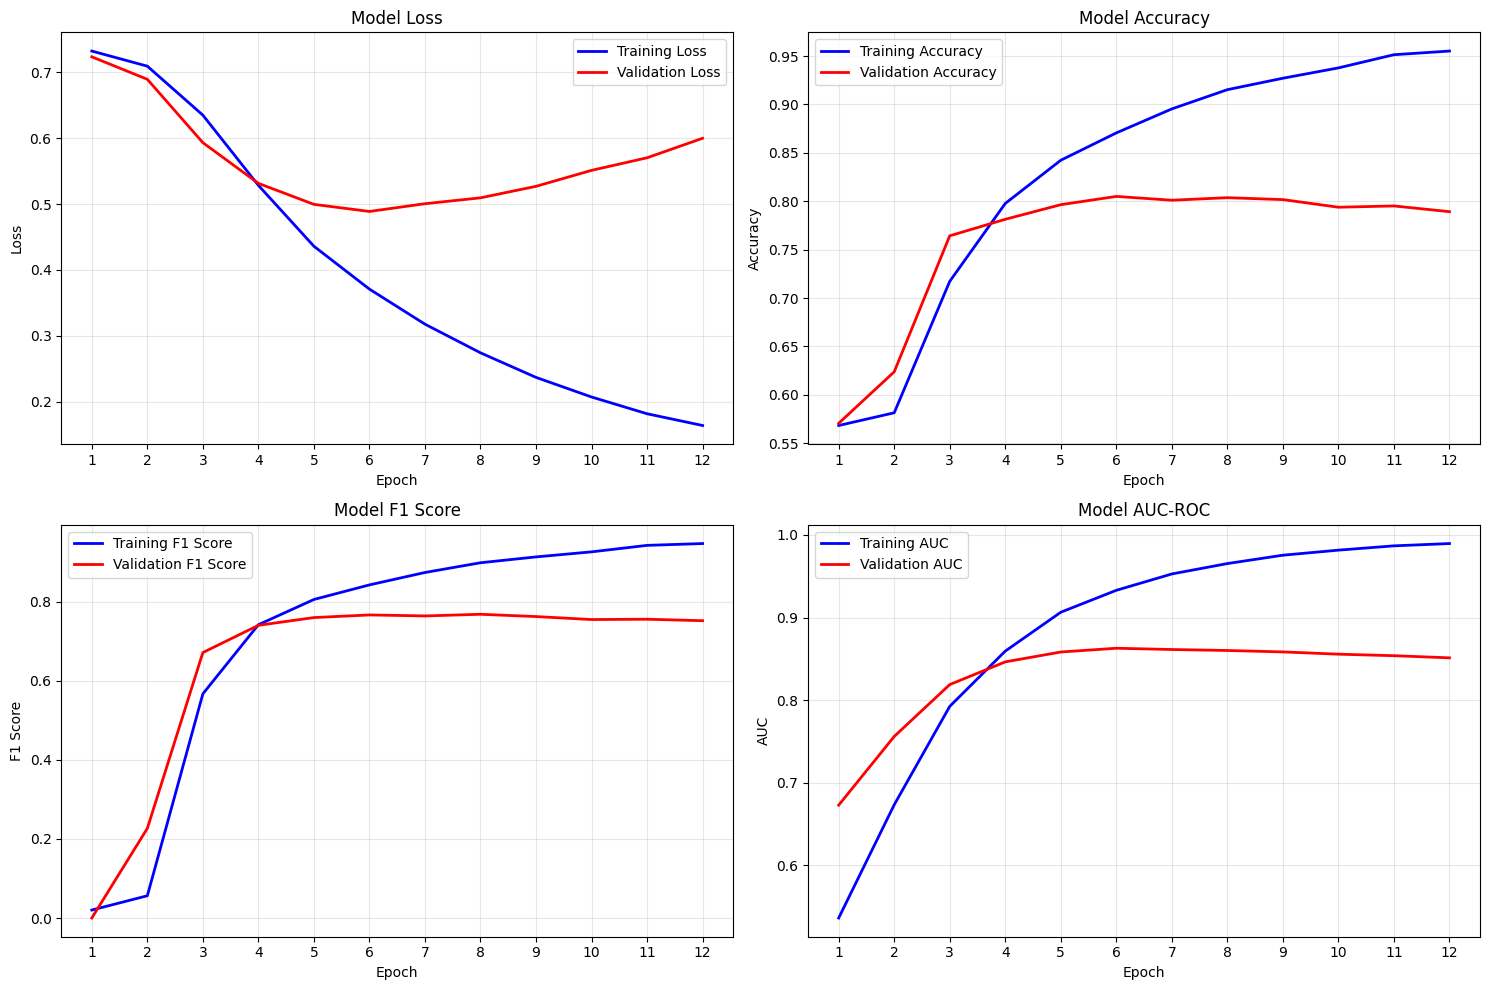

Learning Rate: 5e-05
Embedding Dimension: 256
Batch Size: 32

Results:
Loss: 0.5999
Accuracy: 0.7892
Training F1 Score: 0.9473
Validation F1 Score: 0.7521


In [184]:
LEARNING_RATE = 0.00005
EMB_DIM = 256
BATCH_SIZE = 32

blstm3 = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.1), name='blstm'),

    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2, name='dropout_2'),
    Dense(1, activation='sigmoid', name='output')
])

hist_blstm3 = compile_fit(blstm3)
plot_training_history(hist_blstm3)

worse

reduce emb dim

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 0.5179 - Precision: 0.4242 - Recall: 0.0374 - accuracy: 0.5645 - loss: 0.7347 - val_AUC: 0.6637 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7265
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 0.5179 - Precision: 0.4242 - Recall: 0.0374 - accuracy: 0.5645 - loss: 0.7347 - val_AUC: 0.6637 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7265
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.6165 - Precision: 0.5000 - Recall: 3.8212e-04 - accuracy: 0.5703 - loss: 0.7189 - val_AUC: 0.7000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7087
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.6165 - Precision: 0.5000 - Recall: 3.8212e-04 - accuracy: 0.5703 - loss: 0.7189 - val_AUC: 0.7000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val

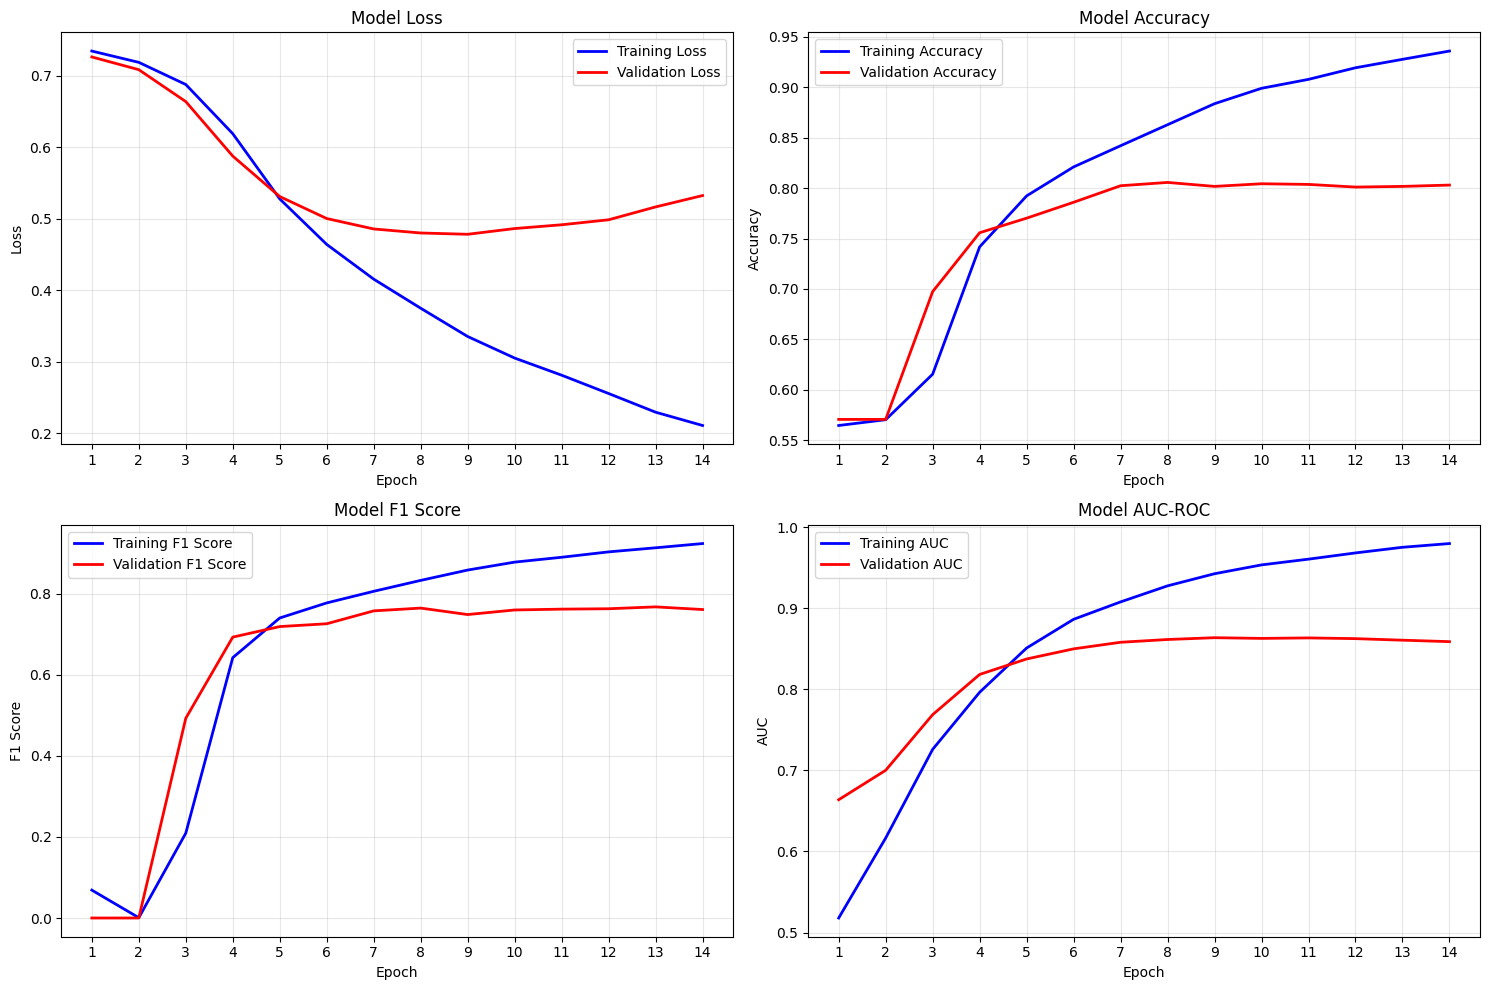

Learning Rate: 5e-05
Embedding Dimension: 64
Batch Size: 32

Results:
Loss: 0.5326
Accuracy: 0.8030
Training F1 Score: 0.9239
Validation F1 Score: 0.7611


In [185]:
LEARNING_RATE = 0.00005
EMB_DIM = 64
BATCH_SIZE = 32

blstm4 = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.1), name='blstm'),

    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2, name='dropout_2'),
    Dense(1, activation='sigmoid', name='output')
])

hist_blstm4 = compile_fit(blstm4)
plot_training_history(hist_blstm4)

slightly better?

l2 regularization

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 0.5052 - Precision: 0.4324 - Recall: 0.0245 - accuracy: 0.5670 - loss: 1.0386 - val_AUC: 0.6424 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 1.0017
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 0.5052 - Precision: 0.4324 - Recall: 0.0245 - accuracy: 0.5670 - loss: 1.0386 - val_AUC: 0.6424 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 1.0017
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5941 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.9711 - val_AUC: 0.7210 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.9420
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5941 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.9711 - val_AUC: 0.7210 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.57

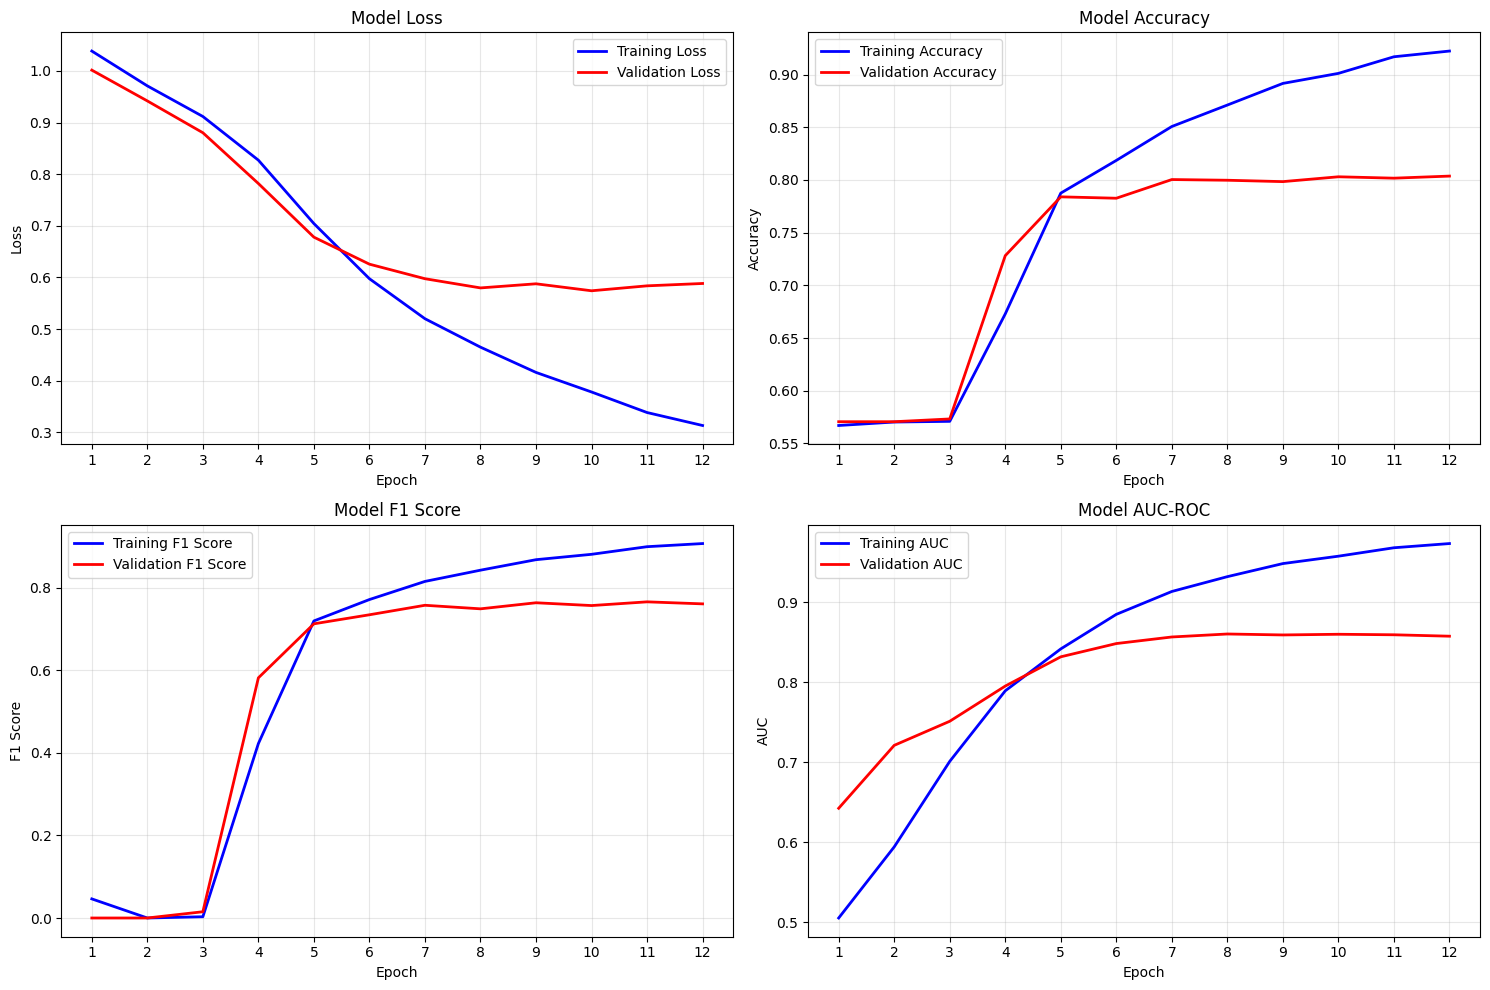

Learning Rate: 5e-05
Embedding Dimension: 64
Batch Size: 32

Results:
Loss: 0.5884
Accuracy: 0.8037
Training F1 Score: 0.9071
Validation F1 Score: 0.7610


In [186]:
LEARNING_RATE = 0.00005
EMB_DIM = 64
BATCH_SIZE = 32

blstm5 = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=l2(0.001), 
                       recurrent_regularizer=l2(0.001)), name='blstm'),

    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2, name='dropout_2'),
    Dense(1, activation='sigmoid', name='output')
])

hist_blstm5 = compile_fit(blstm5)
plot_training_history(hist_blstm5)

slightly better?

higher batch size

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - AUC: 0.5277 - Precision: 0.4481 - Recall: 0.2675 - accuracy: 0.5437 - loss: 1.0574 - val_AUC: 0.5720 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 1.0369
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - AUC: 0.5277 - Precision: 0.4481 - Recall: 0.2675 - accuracy: 0.5437 - loss: 1.0574 - val_AUC: 0.5720 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 1.0369
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 0.5601 - Precision: 0.4000 - Recall: 7.6423e-04 - accuracy: 0.5701 - loss: 1.0179 - val_AUC: 0.6450 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.9989
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 0.5601 - Precision: 0.4000 - Recall: 7.6423e-04 - accuracy: 0.5701 - loss: 1.0179 - val_AUC: 0.6450 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.9

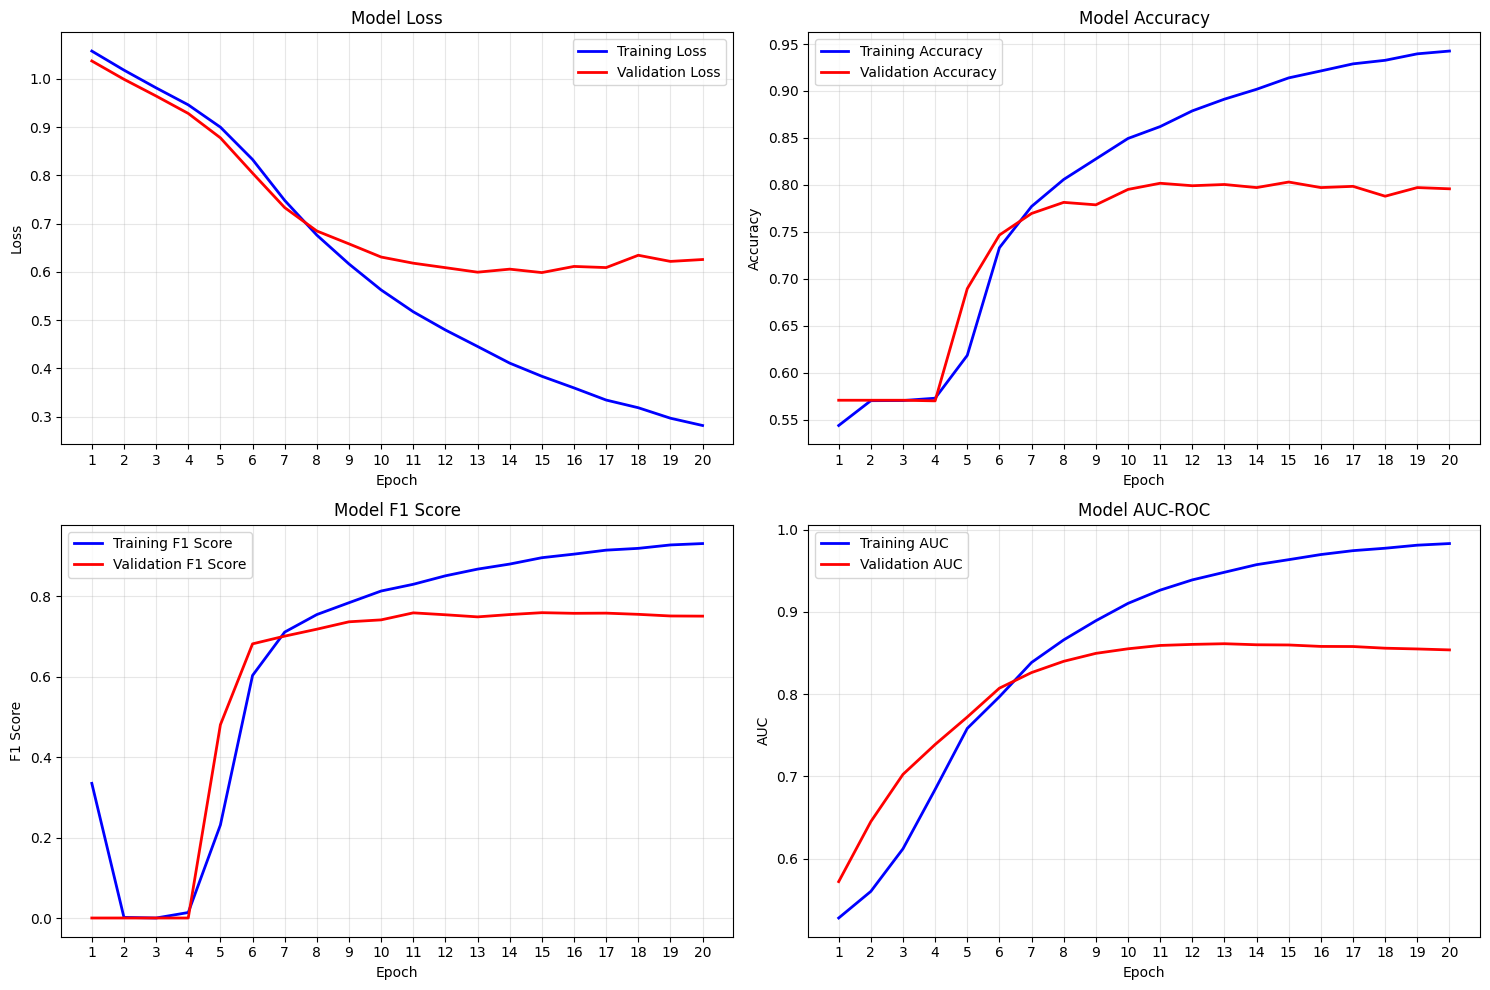

Learning Rate: 5e-05
Embedding Dimension: 64
Batch Size: 64

Results:
Loss: 0.6255
Accuracy: 0.7958
Training F1 Score: 0.9316
Validation F1 Score: 0.7510


In [26]:
LEARNING_RATE = 0.00005
EMB_DIM = 64
BATCH_SIZE = 64

blstm6 = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.1, kernel_regularizer=l2(0.001), 
                       recurrent_regularizer=l2(0.001)), name='blstm'),

    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2, name='dropout_2'),
    Dense(1, activation='sigmoid', name='output')
])

hist_blstm6 = compile_fit(blstm6)
plot_training_history(hist_blstm6)

slightly better, still overfitting

higher dropout

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - AUC: 0.5191 - Precision: 0.4348 - Recall: 0.0076 - accuracy: 0.5693 - loss: 1.0557 - val_AUC: 0.6092 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 1.0344
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - AUC: 0.5191 - Precision: 0.4348 - Recall: 0.0076 - accuracy: 0.5693 - loss: 1.0557 - val_AUC: 0.6092 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 1.0344
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.5516 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 1.0170 - val_AUC: 0.6765 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.9990
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.5516 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 1.0170 - val_AUC: 0.6765 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_l

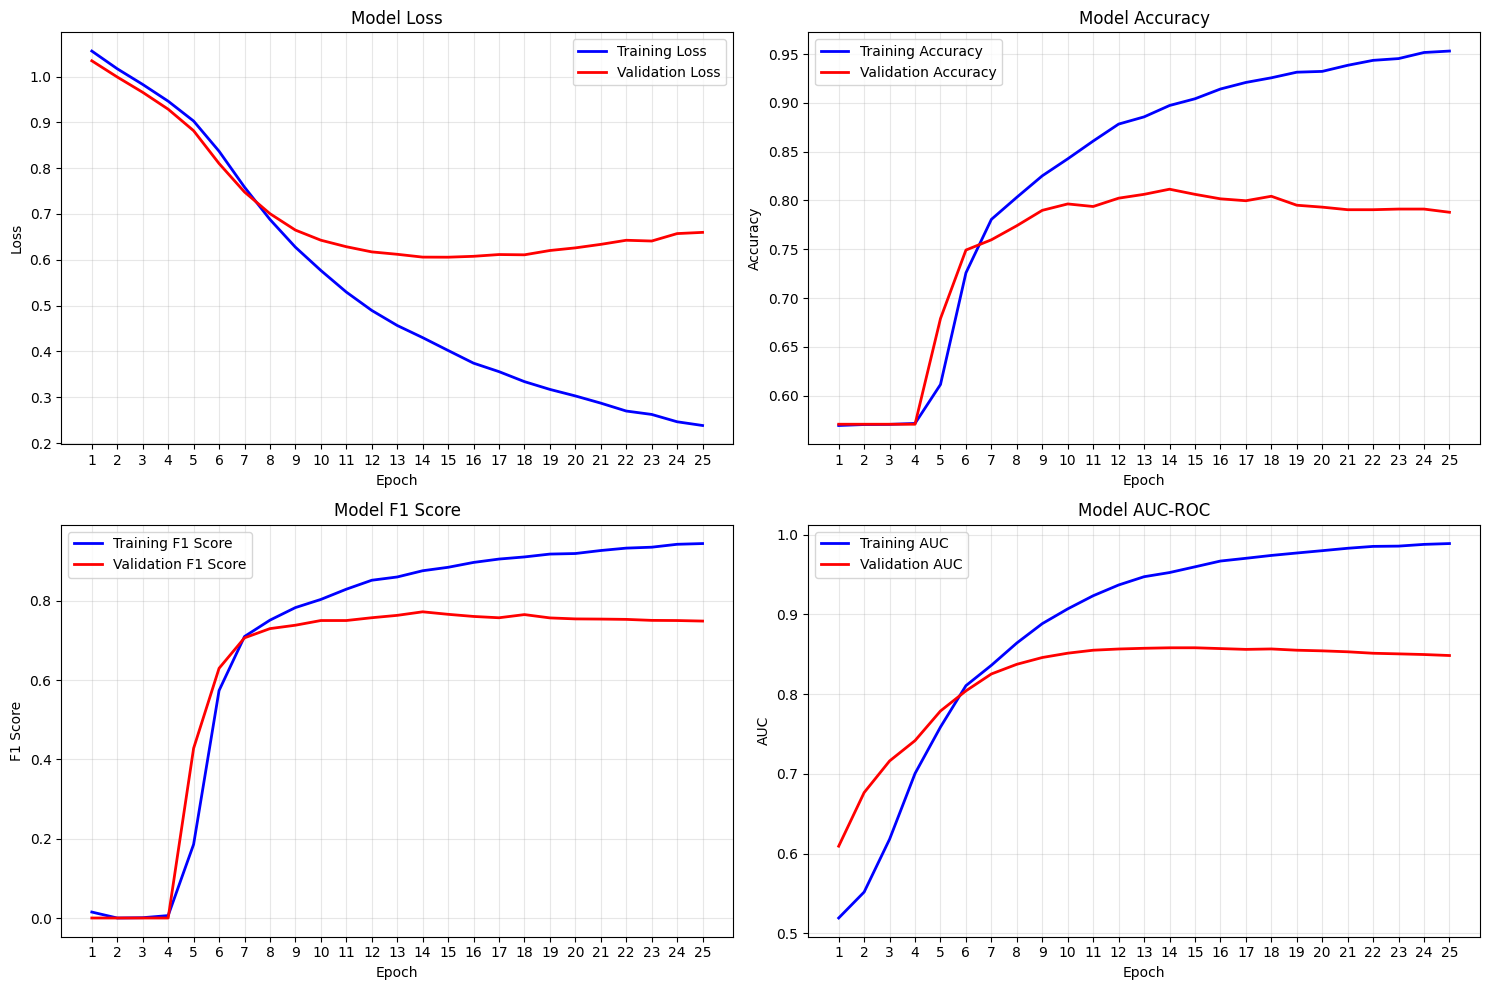

Learning Rate: 5e-05
Embedding Dimension: 64
Batch Size: 64

Results:
Loss: 0.6599
Accuracy: 0.7879
Training F1 Score: 0.9446
Validation F1 Score: 0.7490


In [31]:
LEARNING_RATE = 0.00005
EMB_DIM = 64
BATCH_SIZE = 64

blstm6 = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.001), 
                       recurrent_regularizer=l2(0.001)), name='blstm'),

    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2, name='dropout_2'),
    Dense(1, activation='sigmoid', name='output')
])

hist_blstm6 = compile_fit(blstm6)
plot_training_history(hist_blstm6)

similar scores, less overfitting

higher batch size

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - AUC: 0.5108 - Precision: 0.4426 - Recall: 0.0898 - accuracy: 0.5603 - loss: 1.0675 - val_AUC: 0.5365 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 1.0559
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - AUC: 0.5108 - Precision: 0.4426 - Recall: 0.0898 - accuracy: 0.5603 - loss: 1.0675 - val_AUC: 0.5365 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 1.0559
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - AUC: 0.5366 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 1.0456 - val_AUC: 0.6006 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 1.0349
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - AUC: 0.5366 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 1.0456 - val_AUC: 0.6006 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_l

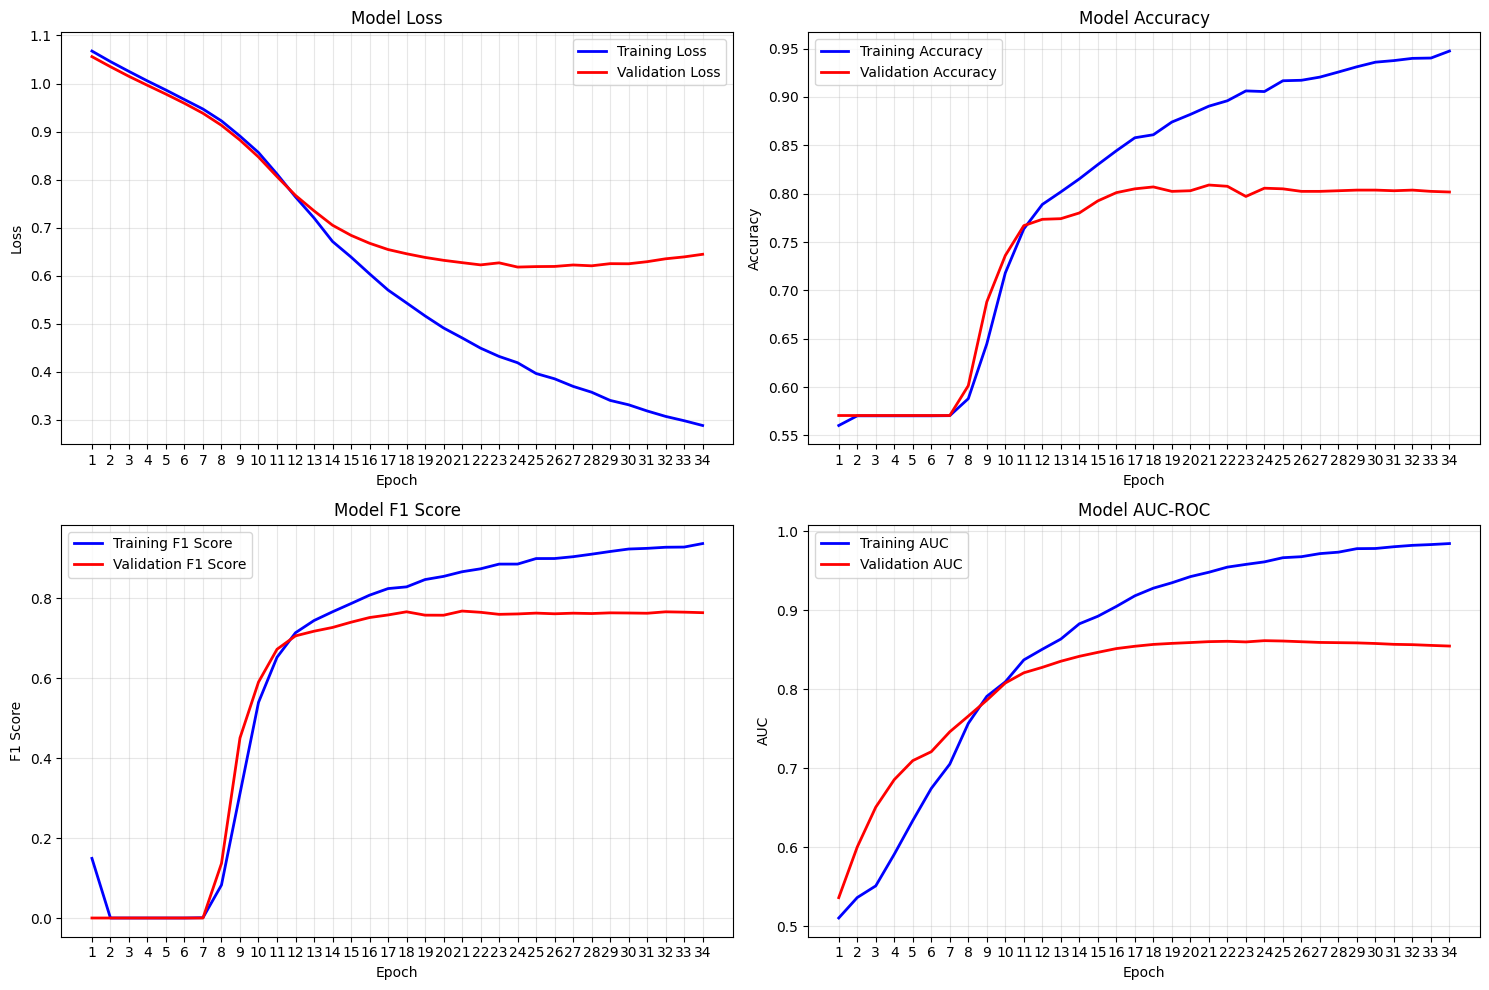

Learning Rate: 5e-05
Embedding Dimension: 64
Batch Size: 128

Results:
Loss: 0.6446
Accuracy: 0.8017
Training F1 Score: 0.9375
Validation F1 Score: 0.7644


In [30]:
LEARNING_RATE = 0.00005
EMB_DIM = 64
BATCH_SIZE = 128

blstm7 = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.001), 
                       recurrent_regularizer=l2(0.001)), name='blstm'),

    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2, name='dropout_2'),
    Dense(1, activation='sigmoid', name='output')
])

hist_blstm7 = compile_fit(blstm7)
plot_training_history(hist_blstm7)

overfitting

higher learning rate

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - AUC: 0.7277 - Precision: 0.7756 - Recall: 0.3156 - accuracy: 0.6667 - loss: 0.7909 - val_AUC: 0.8489 - val_Precision: 0.8367 - val_Recall: 0.6346 - val_accuracy: 0.7899 - val_loss: 0.5548
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - AUC: 0.7277 - Precision: 0.7756 - Recall: 0.3156 - accuracy: 0.6667 - loss: 0.7909 - val_AUC: 0.8489 - val_Precision: 0.8367 - val_Recall: 0.6346 - val_accuracy: 0.7899 - val_loss: 0.5548
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - AUC: 0.9003 - Precision: 0.8655 - Recall: 0.7524 - accuracy: 0.8433 - loss: 0.4539 - val_AUC: 0.8455 - val_Precision: 0.7563 - val_Recall: 0.7401 - val_accuracy: 0.7859 - val_loss: 0.5316
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - AUC: 0.9003 - Precision: 0.8655 - Recall: 0.7524 - accuracy: 0.8433 - loss: 0.4539 - val_AUC: 0.8455 - val_Precision: 0.7563 - val_Recall: 0.7401 - val_accuracy: 0.7859 - val_loss: 0.5316
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━

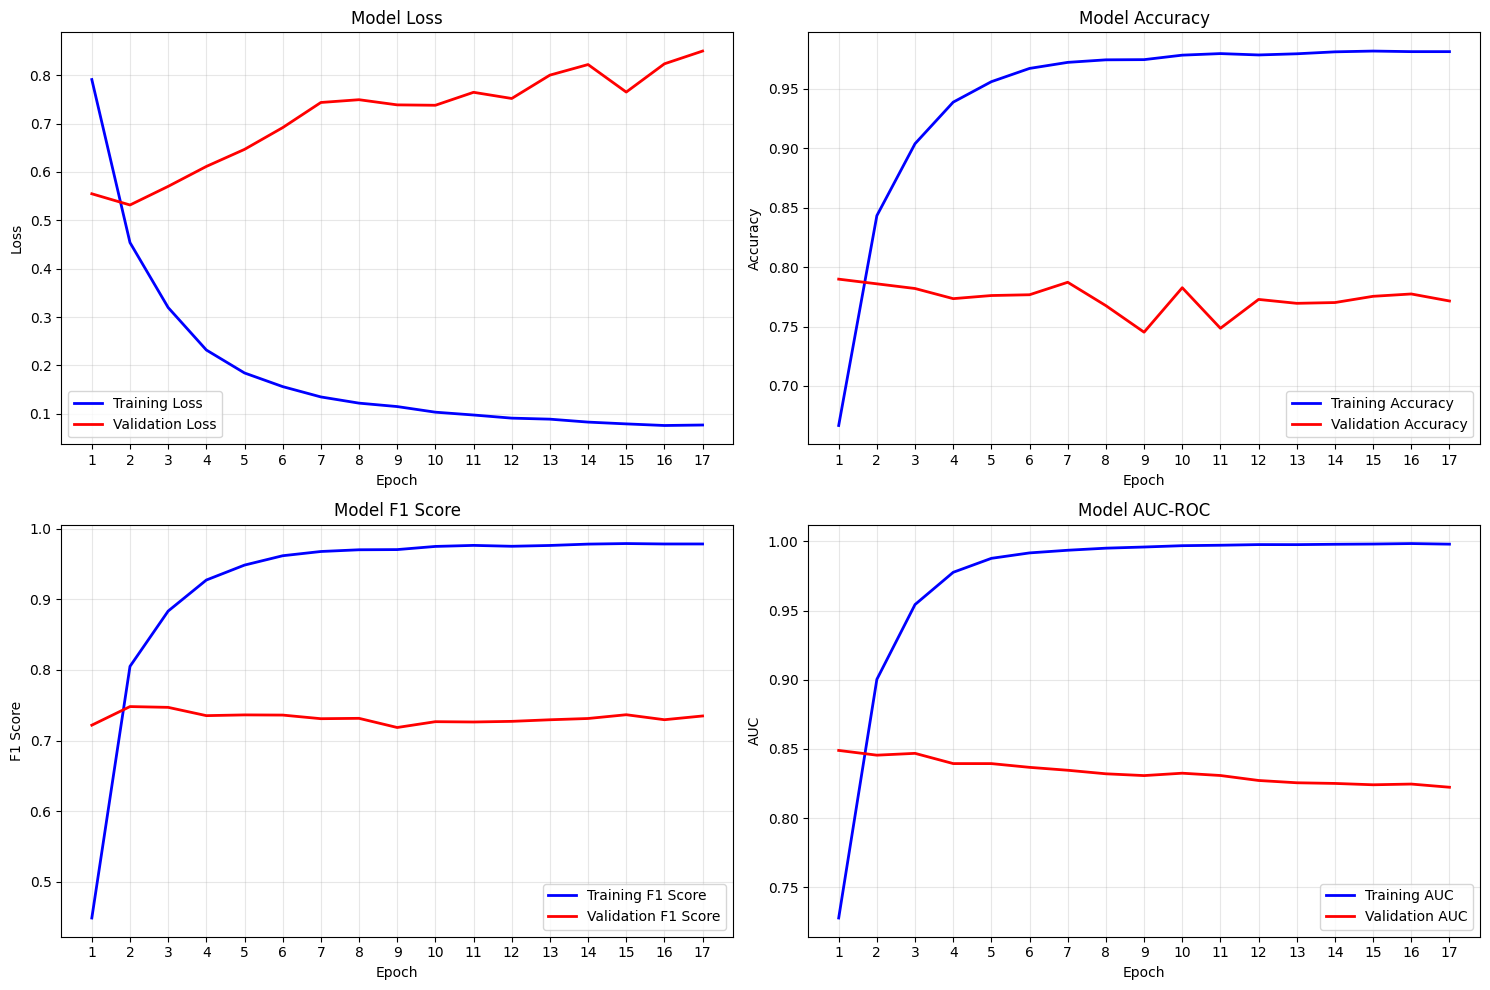

Learning Rate: 0.001
Embedding Dimension: 64
Batch Size: 64

Results:
Loss: 0.8498
Accuracy: 0.7715
Training F1 Score: 0.9783
Validation F1 Score: 0.7348


In [33]:
LEARNING_RATE = 0.001
EMB_DIM = 64
BATCH_SIZE = 64

blstm9 = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.001), 
                       recurrent_regularizer=l2(0.001)), name='blstm'),

    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2, name='dropout_2'),
    Dense(1, activation='sigmoid', name='output')
])

hist_blstm9 = compile_fit(blstm9)
plot_training_history(hist_blstm9)

bad

higher dropout

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - AUC: 0.4975 - Precision: 0.3941 - Recall: 0.0974 - accuracy: 0.5478 - loss: 1.1837 - val_AUC: 0.5497 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 1.1548
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - AUC: 0.4975 - Precision: 0.3941 - Recall: 0.0974 - accuracy: 0.5478 - loss: 1.1837 - val_AUC: 0.5497 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 1.1548
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - AUC: 0.5426 - Precision: 0.4000 - Recall: 7.6423e-04 - accuracy: 0.5701 - loss: 1.1298 - val_AUC: 0.6365 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 1.1054
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - AUC: 0.5426 - Precision: 0.4000 - Recall: 7.6423e-04 - accuracy: 0.5701 - loss: 1.1298 - val_AUC: 0.6365 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 1

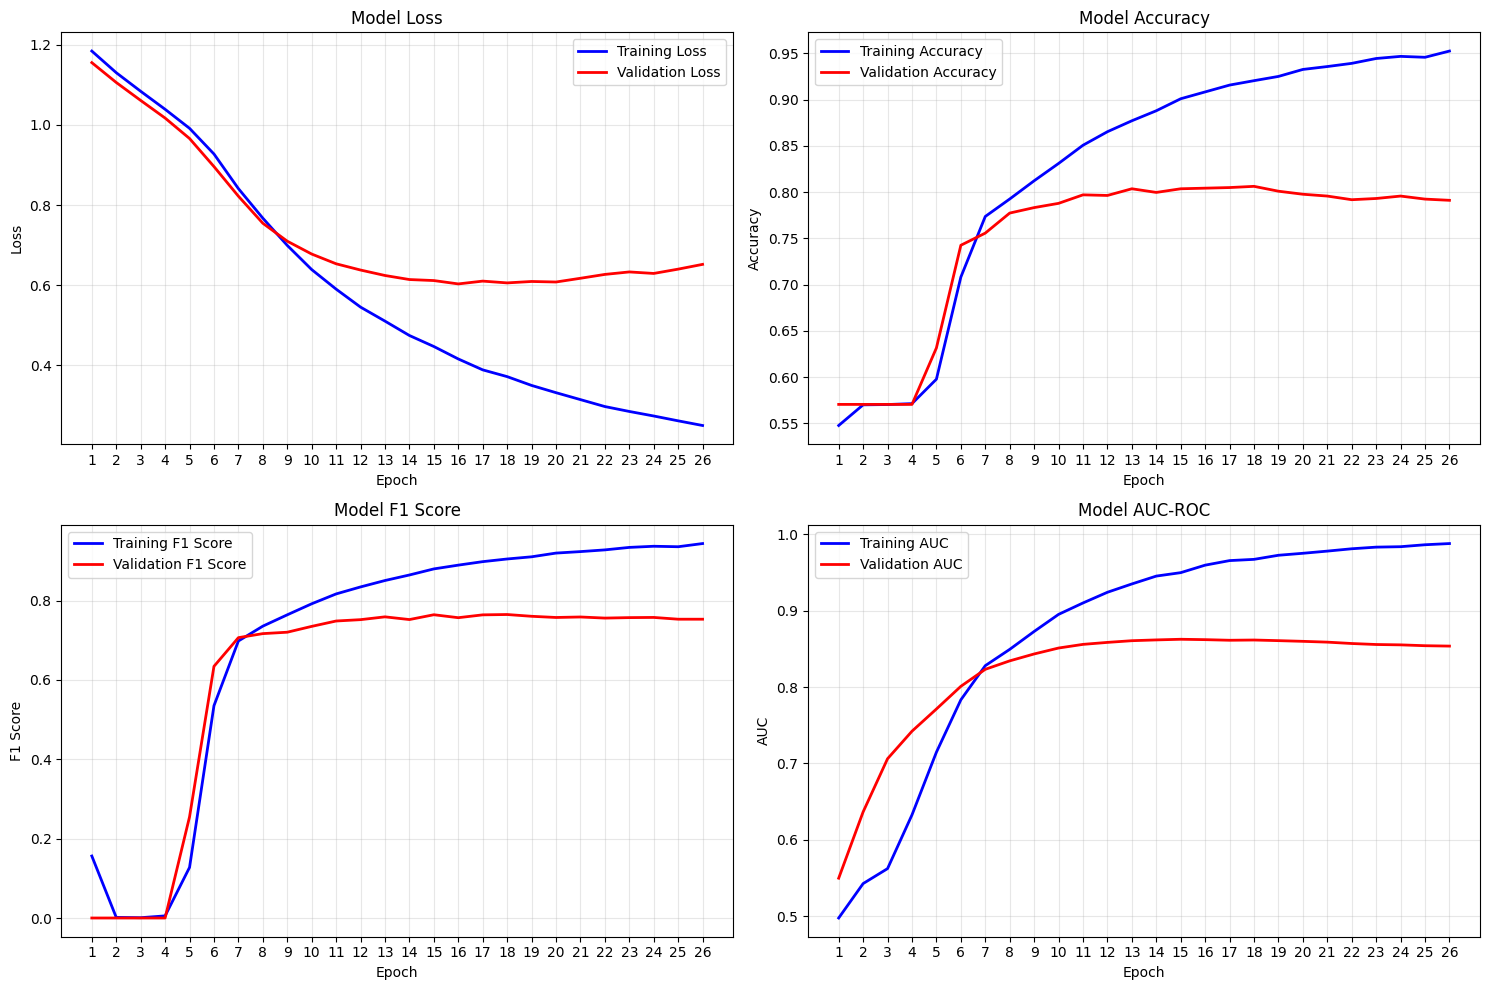

Learning Rate: 5e-05
Embedding Dimension: 128
Batch Size: 64

Results:
Loss: 0.6520
Accuracy: 0.7912
Training F1 Score: 0.9438
Validation F1 Score: 0.7531


In [34]:
LEARNING_RATE = 0.00005
EMB_DIM = 128
BATCH_SIZE = 64

blstm10 = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=l2(0.001), 
                       recurrent_regularizer=l2(0.001)), name='blstm'),

    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3, name='dropout_2'),
    Dense(1, activation='sigmoid', name='output')
])

hist_blstm10 = compile_fit(blstm10)
plot_training_history(hist_blstm10)

marginally better?


***
# Results and Conclusions
***

## Hparam tuning summary

## Results

final model results, params, and architecture

table comparing lstm and blstm

why each param was good as it was and what improved performance best

what didn't work

## Conclusions

learnings/takeaways

what i could try later

### References

> 1. Culliton, Phil. “NLP Getting Started Tutorial.” Kaggle, Kaggle, 20 Dec. 2019, www.kaggle.com/code/philculliton/nlp-getting-started-tutorial. 

> 2. Evitan, Gunes. “NLP with Disaster Tweets - Eda, Cleaning and Bert.” Kaggle, Kaggle, 4 Feb. 2020, www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert. 

> 3. Audevart, Alexia. “Kerasnlp Starter Notebook Disaster Tweets.” Kaggle, Kaggle, 2 Aug. 2023, www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets/notebook. 

*AI Use/Citation:*

Github Copilot (Claude) was used during the development of this project. It's use was limited to:
- syntax correction/improvement
- code suggestions for small operations
- improving formatting of code
- nicely formatting print statements and statistics
- suggesting certain functions for plots I was trying to make
- making plots look and scale better

All ideas for every step of the project came from me.

In [2]:
def clean_text(text):
    text = re.sub(r'http\S+', 'url', text) # replaces URLs with 'url'
    text = re.sub(r'#(\w+)', r' hashtag \1 ', text) # replaces hashtags with 'hashtag' followed by the tag
    text = re.sub(r'@(\w+)', r' mention \1 ', text) # replaces mentions with 'mention' followed by the username
    text = re.sub(r'[^a-zA-Z0-9\s!?.]', '', text) # removes special characters except for !, ?, and .
    text = re.sub(r'\s+', ' ', text).strip() # cleans excess whitespace
    return text

In [3]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

train_data['text_clean'] = train_data['text'].apply(clean_text)
test_data['text_clean'] = test_data['text'].apply(clean_text)

In [5]:
MAX_VOCAB_SIZE = 30000  # maximum vocabulary size
MAX_SEQUENCE_LENGTH = 35  # maximum tweet length

# Create tokenizer for text
text_tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    oov_token="<OOV>",
    lower=True
)

all_texts = list(train_data['text_clean']) + list(test_data['text_clean'])
text_tokenizer.fit_on_texts(all_texts)

train_text_sequences = text_tokenizer.texts_to_sequences(train_data['text_clean'])
test_text_sequences = text_tokenizer.texts_to_sequences(test_data['text_clean'])
# padding sequences to same length
X_train_seq = pad_sequences(train_text_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_seq = pad_sequences(test_text_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_seq, train_data['target'].values, test_size=0.2, random_state=42, stratify=train_data['target'].values
)

In [7]:
early_stopping_rnn = EarlyStopping(
    monitor='val_accuracy',
    patience=4,
    restore_best_weights=True,
    verbose=1,
    start_from_epoch=7
)

vocab_size = min(MAX_VOCAB_SIZE, len(text_tokenizer.word_index)) + 1

def compile_fit(model, training_epochs=50,early_stopping=True):
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=METRICS
    )

    return model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=training_epochs,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping_rnn] if early_stopping else [],
        verbose=1
    ).history

In [8]:
LEARNING_RATE = 0.00005
EMB_DIM = 64
METRICS = ['accuracy', 'Precision', 'Recall', 'AUC']
BATCH_SIZE = 32

blstm = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    Bidirectional(LSTM(16, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.0001), 
                       recurrent_regularizer=l2(0.0001))),

    Dense(1, activation='sigmoid')
])

hist_blstm = compile_fit(blstm, training_epochs=15, early_stopping=False)

Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 0.5395 - Precision: 0.5000 - Recall: 3.8212e-04 - accuracy: 0.5703 - loss: 0.7006 - val_AUC: 0.6367 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6965
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 0.5395 - Precision: 0.5000 - Recall: 3.8212e-04 - accuracy: 0.5703 - loss: 0.7006 - val_AUC: 0.6367 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6965
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - AUC: 0.6273 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.6931 - val_AUC: 0.6992 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6908
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - AUC: 0.6273 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.6931 - val_AUC: 0.6992 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy

NameError: name 'plot_training_history' is not defined

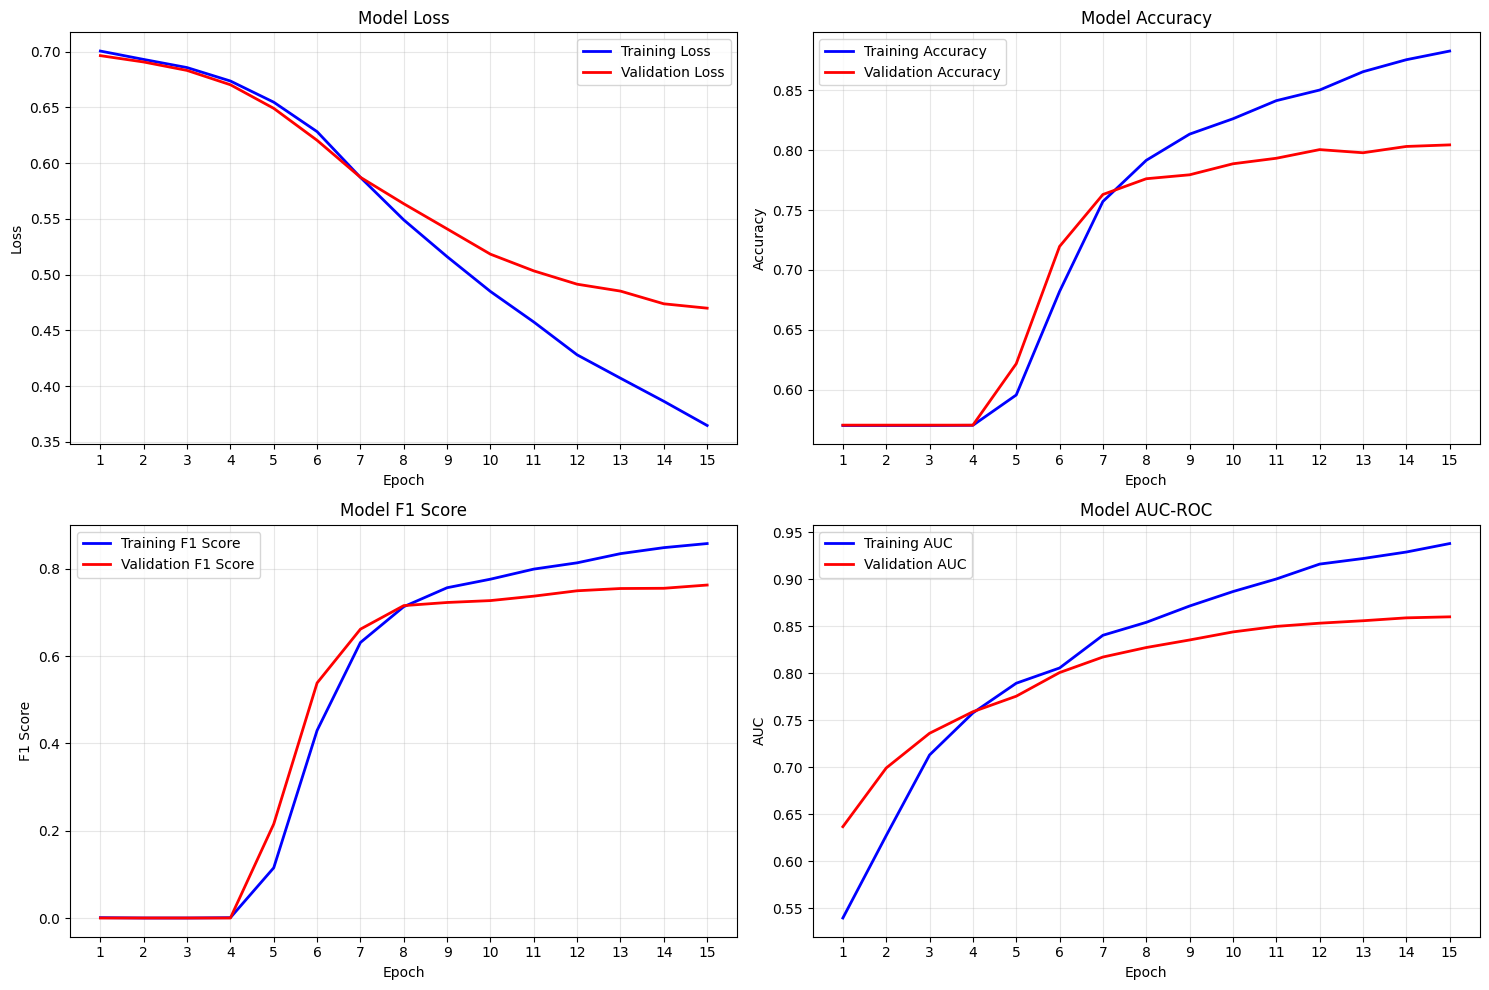

Learning Rate: 5e-05
Embedding Dimension: 64
Batch Size: 32

Results:
Loss: 0.4699
Accuracy: 0.8043
Training F1 Score: 0.8578
Validation F1 Score: 0.7627


In [10]:
plot_training_history(hist_blstm)